# Imports

In [246]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mc
import colorsys
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

# helper for displaying dataframes in a scrollable div
def scrollable_df(df, max_height=400, max_width=800):
    return HTML(f"""
        <div style="
            max-height: {max_height}px;
            max-width: {max_width}px;
            overflow: auto;
            border: 1px solid #ccc;
            padding: 10px;
            font-family: monospace;
        ">
        {df.to_html(border=0)}
        </div>
    """)


# Datset Preparation

In [247]:
# import vessel data
base_path = r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2"
vessel_files = [
    "vessel_features_training.csv",
    "vessel_features_testing_on.csv",
    "vessel_features_testing_off.csv"
]
vessel_dfs = [pd.read_csv(os.path.join(base_path, f), header=None) for f in vessel_files]
vessel_data = pd.concat(vessel_dfs, ignore_index=True)
vessel_data.columns = vessel_data.iloc[0]
vessel_data = vessel_data[1:]  
vessel_data = vessel_data.reset_index(drop=True)
# remove dataset name column
# vessel_data = vessel_data.drop(columns=["dataset"])
vessel_data.head(5)

,dataset,name,vessel_density,dens_0_0,dens_0_1,dens_1_0,dens_1_1,fractal_dim,branch_angle,mean_width,std_width
0,Training Set,0_left,0.01801300048828125,0.0138397216796875,0.0124359130859375,0.01580810546875,0.02996826171875,1.4884142511399534,95.73804503857886,1.133849,0.32020256
1,Training Set,0_right,0.03713226318359375,0.0128326416015625,0.071807861328125,0.0027313232421875,0.0611572265625,1.4757333587544241,100.01678563856103,1.5397811,0.69020337
2,Training Set,1005_left,0.058506011962890625,0.0861053466796875,0.0487823486328125,0.0625457763671875,0.036590576171875,1.5895826613269979,99.86612853249859,1.491264,0.6855102
3,Training Set,1005_right,0.06177520751953125,0.0563201904296875,0.08154296875,0.0383758544921875,0.07086181640625,1.6043249001119033,99.75273115759727,1.4625292,0.65080965
4,Training Set,1006_left,0.04608917236328125,0.057037353515625,0.0329437255859375,0.068328857421875,0.0260467529296875,1.559135435274988,99.22989212453189,1.362923,0.56936383


In [248]:
# import annotations
annotation_files = {
    'training': "training annotation.csv",
    'on-site': "on-site test annotation.csv",
    'off-site': "off-site test annotation.csv"
}

annotation_dfs = []
for set_name, fname in annotation_files.items():
    df = pd.read_csv(os.path.join(base_path, fname))
    annotation_dfs.append(df)

annotations = pd.concat(annotation_dfs, ignore_index=True)
#drop first column
annotations = annotations.iloc[:, :15]
# remove .jpg from Left-Fundus and Right-Fundus columns
annotations['Left-Fundus'] = annotations['Left-Fundus'].str.replace('.jpg', '', regex=False)
annotations['Right-Fundus'] = annotations['Right-Fundus'].str.replace('.jpg', '', regex=False)

annotations.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left,0_right,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left,1_right,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left,2_right,laser spot?moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left,3_right,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left,4_right,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [249]:
# reshape annotations
label_cols = ['N','D','G','C','A','H','M','O']

def reshape_annotations(df):
    left = df[['ID', 'Patient Age', 'Patient Sex','Left-Fundus'] + label_cols].copy()
    right = df[['ID', 'Patient Age', 'Patient Sex', 'Right-Fundus'] + label_cols].copy()

    left.columns = ['ID', 'Patient_Age','Patient Sex' ,'Image'] + label_cols
    right.columns = ['ID', 'Patient_Age','Patient Sex' ,'Image'] + label_cols

    return left, right

annotations_reshaped_left, annotations_reshaped_right = reshape_annotations(annotations)
annotations_reshaped_left.head(5)

,ID,Patient_Age,Patient Sex,Image,N,D,G,C,A,H,M,O
0,0,69,Female,0_left,0,0,0,1,0,0,0,0
1,1,57,Male,1_left,1,0,0,0,0,0,0,0
2,2,42,Male,2_left,0,1,0,0,0,0,0,1
3,3,66,Male,3_left,0,0,0,0,0,0,0,1
4,4,53,Male,4_left,0,1,0,0,0,0,0,1


In [250]:
vessel_data = vessel_data.rename(columns={'name': 'Image'})
merged_data_left = pd.merge(vessel_data, annotations_reshaped_left, left_on='Image', right_on='Image', how='inner')
merged_data_right = pd.merge(vessel_data, annotations_reshaped_right, left_on='Image', right_on='Image', how='inner')
merged_data_left.head(5)

,dataset,Image,vessel_density,dens_0_0,dens_0_1,dens_1_0,dens_1_1,fractal_dim,branch_angle,mean_width,...,Patient_Age,Patient Sex,N,D,G,C,A,H,M,O
0,Training Set,0_left,0.01801300048828125,0.0138397216796875,0.0124359130859375,0.01580810546875,0.02996826171875,1.4884142511399534,95.73804503857886,1.133849,...,69,Female,0,0,0,1,0,0,0,0
1,Training Set,1005_left,0.058506011962890625,0.0861053466796875,0.0487823486328125,0.0625457763671875,0.036590576171875,1.5895826613269979,99.86612853249859,1.491264,...,78,Female,0,0,0,0,0,0,0,1
2,Training Set,1006_left,0.04608917236328125,0.057037353515625,0.0329437255859375,0.068328857421875,0.0260467529296875,1.559135435274988,99.22989212453189,1.362923,...,64,Male,0,0,0,0,0,0,0,1
3,Training Set,1008_left,0.07656478881835938,0.091705322265625,0.0712127685546875,0.0817718505859375,0.0615692138671875,1.6437332918214616,99.95321970647544,1.4917977,...,65,Male,0,0,0,0,0,0,0,1
4,Training Set,100_left,0.08580780029296875,0.109344482421875,0.0721282958984375,0.0933380126953125,0.06842041015625,1.674092795957605,100.02591472251353,1.5386016,...,59,Male,0,0,0,0,0,0,0,1


In [251]:
# save the cleaned data
merged_data_left.to_csv(os.path.join(base_path, "vessel_features_cleaned_left.csv"), index=False)
merged_data_right.to_csv(os.path.join(base_path, "vessel_features_cleaned_right.csv"), index=False)

# Statistics

In [245]:
# remove outliers
merged_data_left = merged_data_left.drop(columns=['dataset'])
merged_data_right = merged_data_right.drop(columns=['dataset'])
merged_data_left['Patient_ID'] = merged_data_left['Image'].str.replace('_left', '', regex=False)
merged_data_right['Patient_ID'] = merged_data_right['Image'].str.replace('_right', '', regex=False)

common_ids = set(merged_data_left['Patient_ID']).intersection(set(merged_data_right['Patient_ID']))
merged_data_left = merged_data_left[merged_data_left['Patient_ID'].isin(common_ids)]
merged_data_right = merged_data_right[merged_data_right['Patient_ID'].isin(common_ids)]

measurement_cols = [
    'vessel_density', 'dens_0_0', 'dens_0_1',
    'dens_1_0', 'dens_1_1', 'fractal_dim',
    'mean_width', 'std_width', 'Patient_Age'
]

def remove_outliers(df, cols):
    df_clean = df.copy()
    for col in cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # Convert to numeric
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        mask = (df_clean[col] >= (q1 -2.5 * iqr)) & (df_clean[col] <= (q3 + 2.5 * iqr))
        df_clean = df_clean[mask]
    return df_clean

merged_data_left = remove_outliers(merged_data_left, measurement_cols)
merged_data_right = remove_outliers(merged_data_right, measurement_cols)

# keep only the patients that are present in both datasets
merged_data_left = merged_data_left[merged_data_left['Patient_ID'].isin(merged_data_right['Patient_ID'])]
merged_data_right = merged_data_right[merged_data_right['Patient_ID'].isin(merged_data_left['Patient_ID'])]
merged_data_left.shape, merged_data_right.shape

((4521, 22), (4521, 22))

In [105]:
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
disease_name_map = {
    'N': 'NORMAL',
    'D': 'DIABETIC_RETINOPATHY',
    'G': 'GLAUCOMA',
    'C': 'CATARACT',
    'A': 'AGE_REL_MACULAR_DEG',
    'H': 'HYPERTENSION',
    'M': 'MYOPIA',
    'O': 'OTHER_DISEASES'
}

# def compute_stats_se(df):
#     stats = []
#     for disease in diseases:
#         subset = df[df[disease] == 1]
#         row = {'Disease': disease_name_map[disease]}
#         for col in measurement_cols:
#             vals = pd.to_numeric(subset[col], errors='coerce')
#             row[f'{col}_mean'] = vals.mean()
#             row[f'{col}_se'] = vals.std(ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else 0
#         row['Male'] = subset['Patient Sex'].value_counts().get('Male', 0)
#         row['Female'] = subset['Patient Sex'].value_counts().get('Female', 0)
#         stats.append(row)
#     return pd.DataFrame(stats)

# left_stats_se = compute_stats_se(merged_data_left)
# right_stats_se = compute_stats_se(merged_data_right)

# Compute mean and SD
def compute_stats_sd(df):
    stats = []
    for disease in diseases:
        subset = df[df[disease] == 1]
        row = {'Disease': disease_name_map[disease]}
        for col in measurement_cols:
            vals = pd.to_numeric(subset[col], errors='coerce')
            row[f'{col}_mean'] = vals.mean()
            row[f'{col}_sd'] = vals.std(ddof=1)
        row['Male'] = subset['Patient Sex'].value_counts().get('Male', 0)
        row['Female'] = subset['Patient Sex'].value_counts().get('Female', 0)
        stats.append(row)
    return pd.DataFrame(stats)

left_stats_sd = compute_stats_sd(merged_data_left)
right_stats_sd = compute_stats_sd(merged_data_right)

In [106]:
# left_stats_se.columns = ['Disease', 'Vessel Density Mean', 'Vessel Density SE',
#                          'Density Top Left Quadrant Mean', 'Density Top Left Quadrant SE',
#                          'Density Top Right Quadrant Mean', 'Density Top Right Quadrant SE',
#                          'Density Bottom Left Quadrant Mean', 'Density Bottom Left Quadrant SE',
#                          'Density Bottom Right Quadrant Mean', 'Density Bottom Right Quadrant SE',
#                          'Fractal Dim Mean', 'Fractal Dim SE',
#                          'Mean Width Mean', 'Mean Width SE',
#                          'Std Width Mean', 'Std Width SE',
#                          'Patient Age Mean', 'Patient Age SE',
#                          'Male', 'Female']

# right_stats_se.columns = left_stats_se.columns.copy()

left_stats_sd.columns = [
    'Disease', 'Vessel Density Mean', 'Vessel Density SD',
    'Density Top Left Quadrant Mean', 'Density Top Left Quadrant SD',
    'Density Top Right Quadrant Mean', 'Density Top Right Quadrant SD',
    'Density Bottom Left Quadrant Mean', 'Density Bottom Left Quadrant SD',
    'Density Bottom Right Quadrant Mean', 'Density Bottom Right Quadrant SD',
    'Fractal Dim Mean', 'Fractal Dim SD',
    'Mean Width Mean', 'Mean Width SD',
    'Std Width Mean', 'Std Width SD',
    'Patient Age Mean', 'Patient Age SD',
    'Male', 'Female'
]

right_stats_sd.columns = left_stats_sd.columns.copy()

clean_measurements = [
    "Vessel Density",
    "Density Top Left Quadrant",
    "Density Top Right Quadrant",
    "Density Bottom Left Quadrant",
    "Density Bottom Right Quadrant",
    "Fractal Dim",
    "Mean Width",
    "Std Width",
    "Patient Age"
]

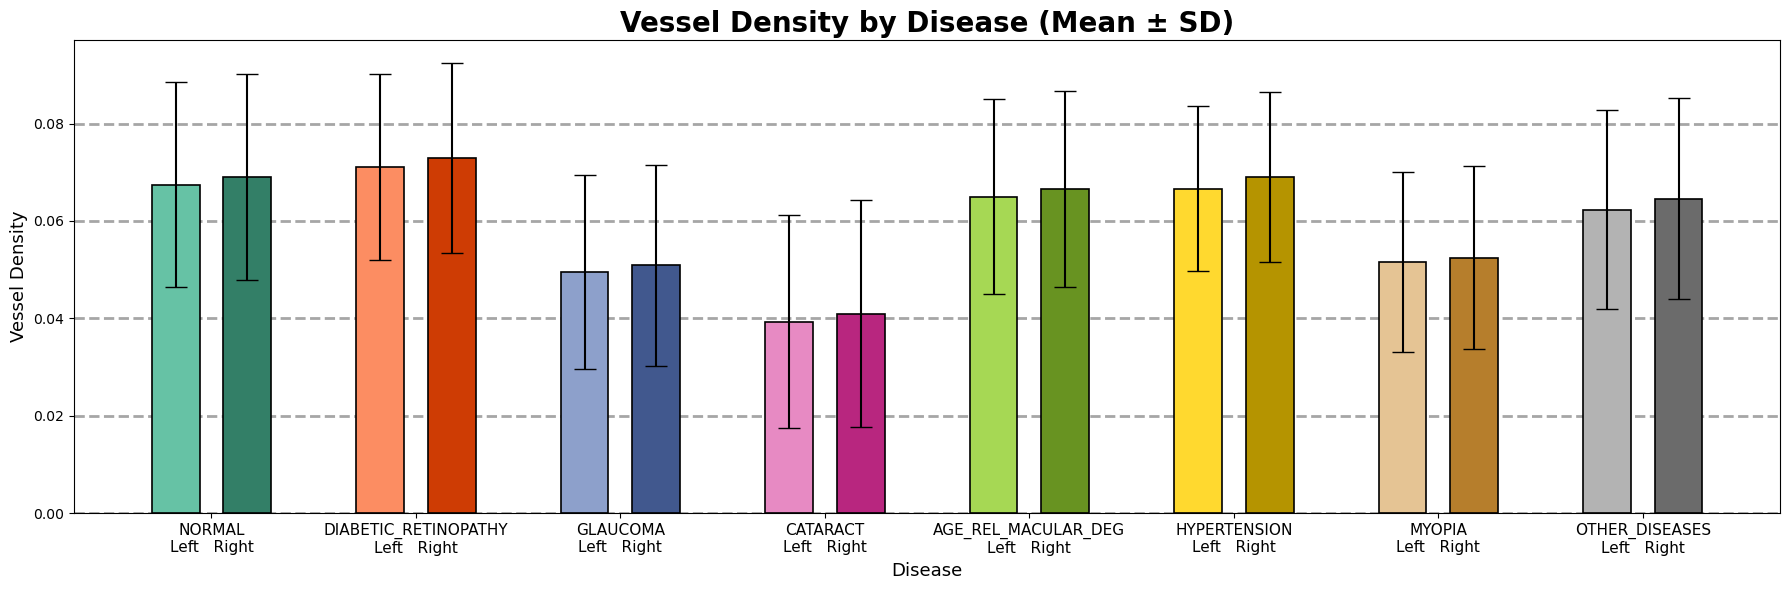

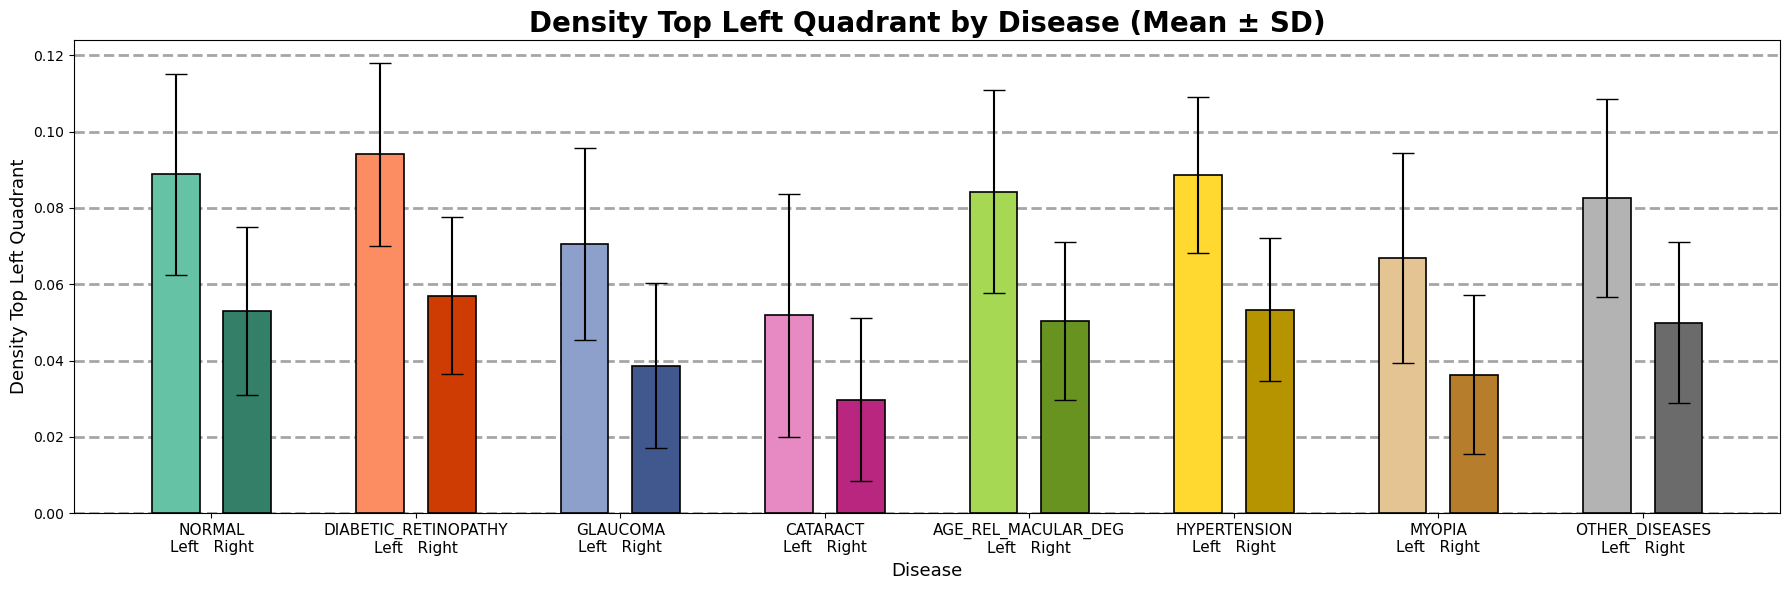

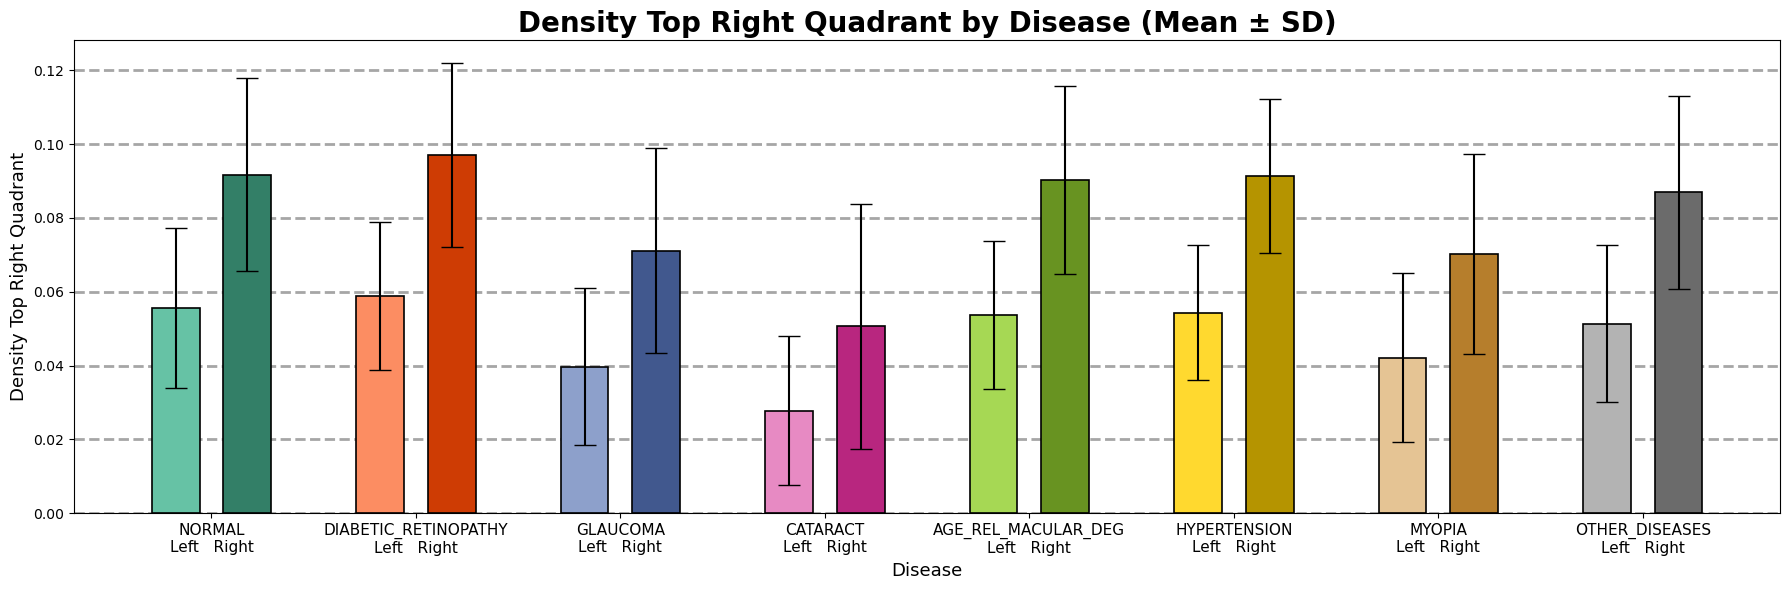

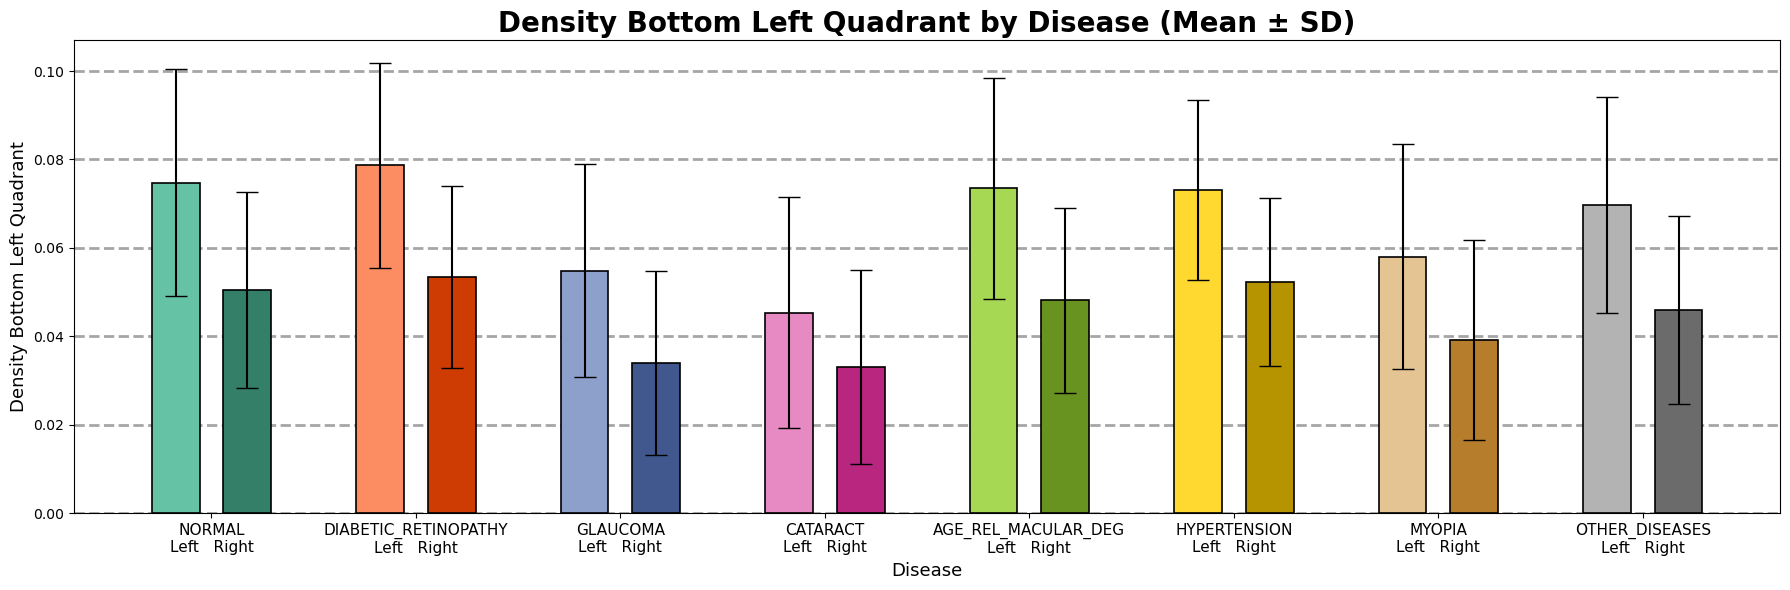

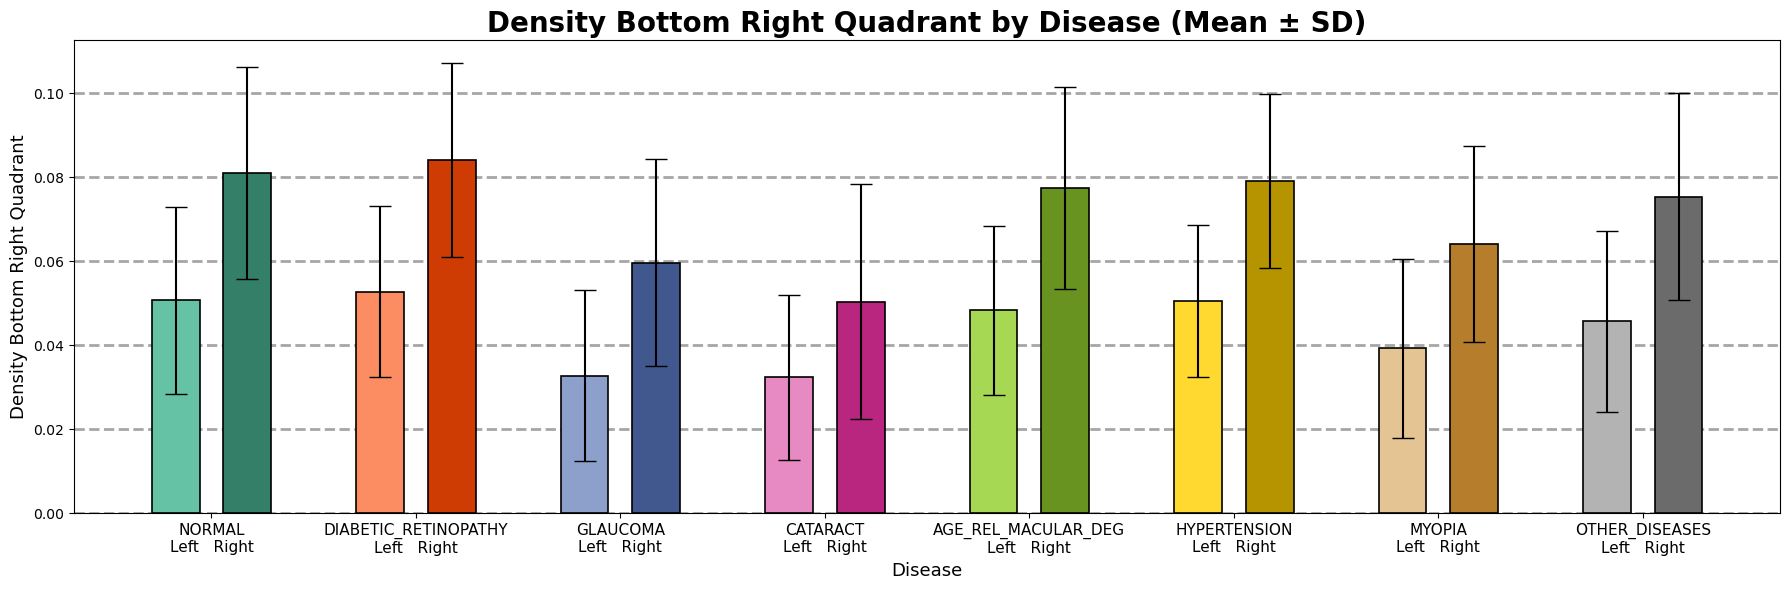

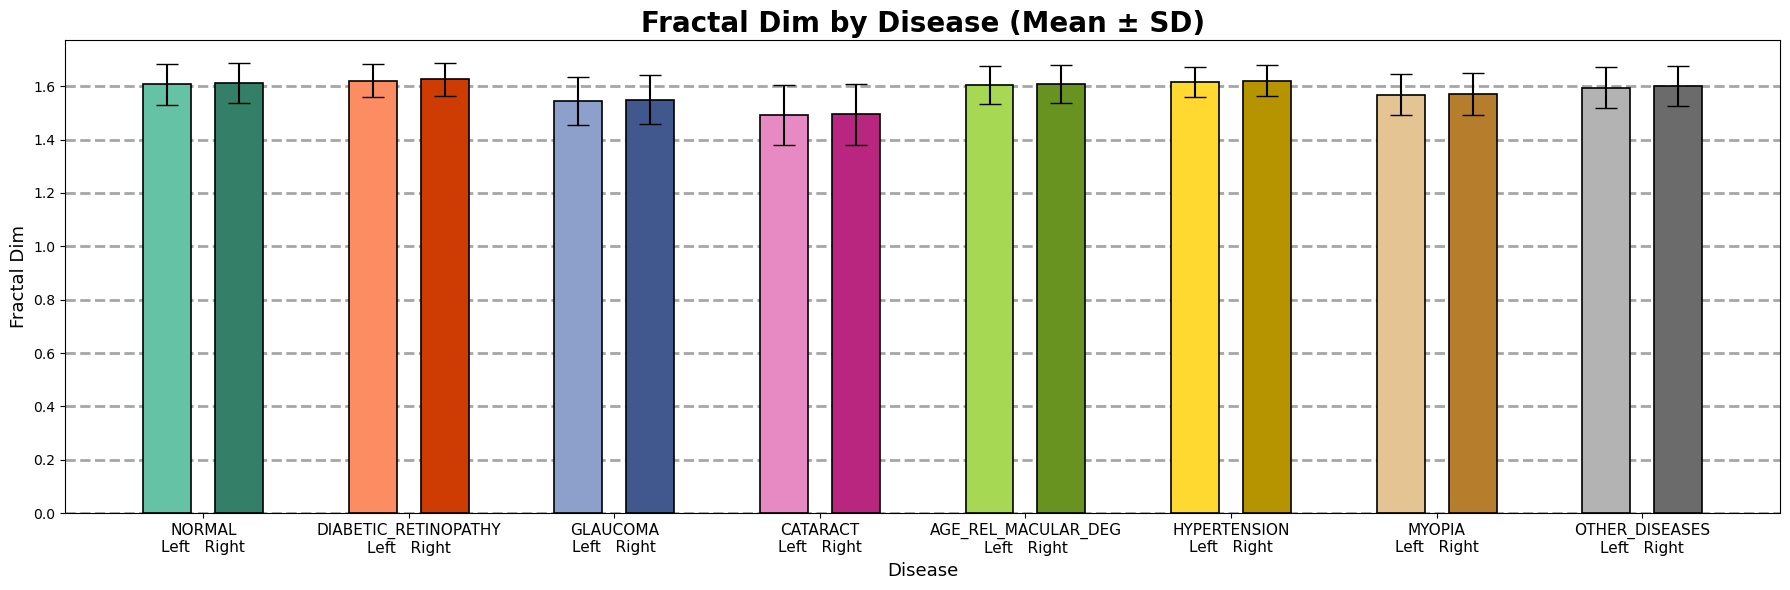

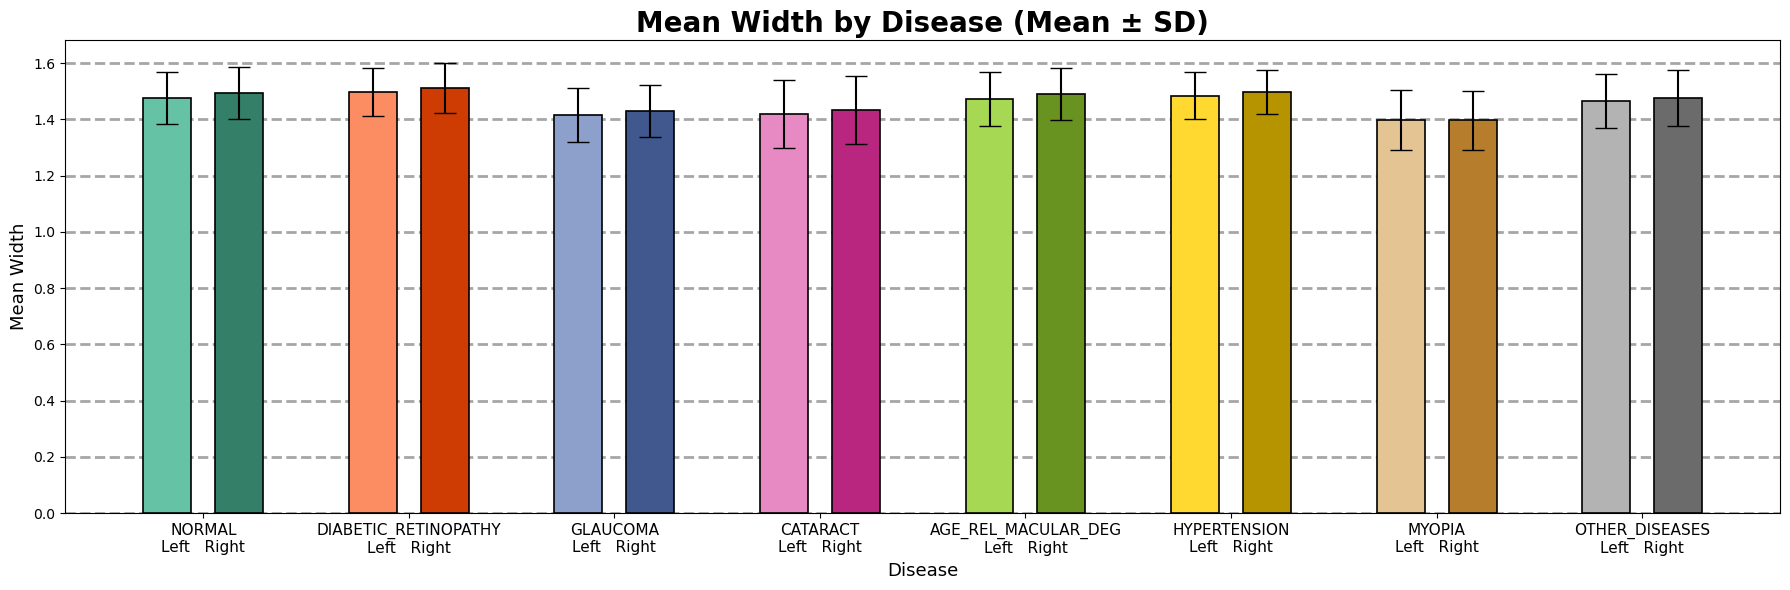

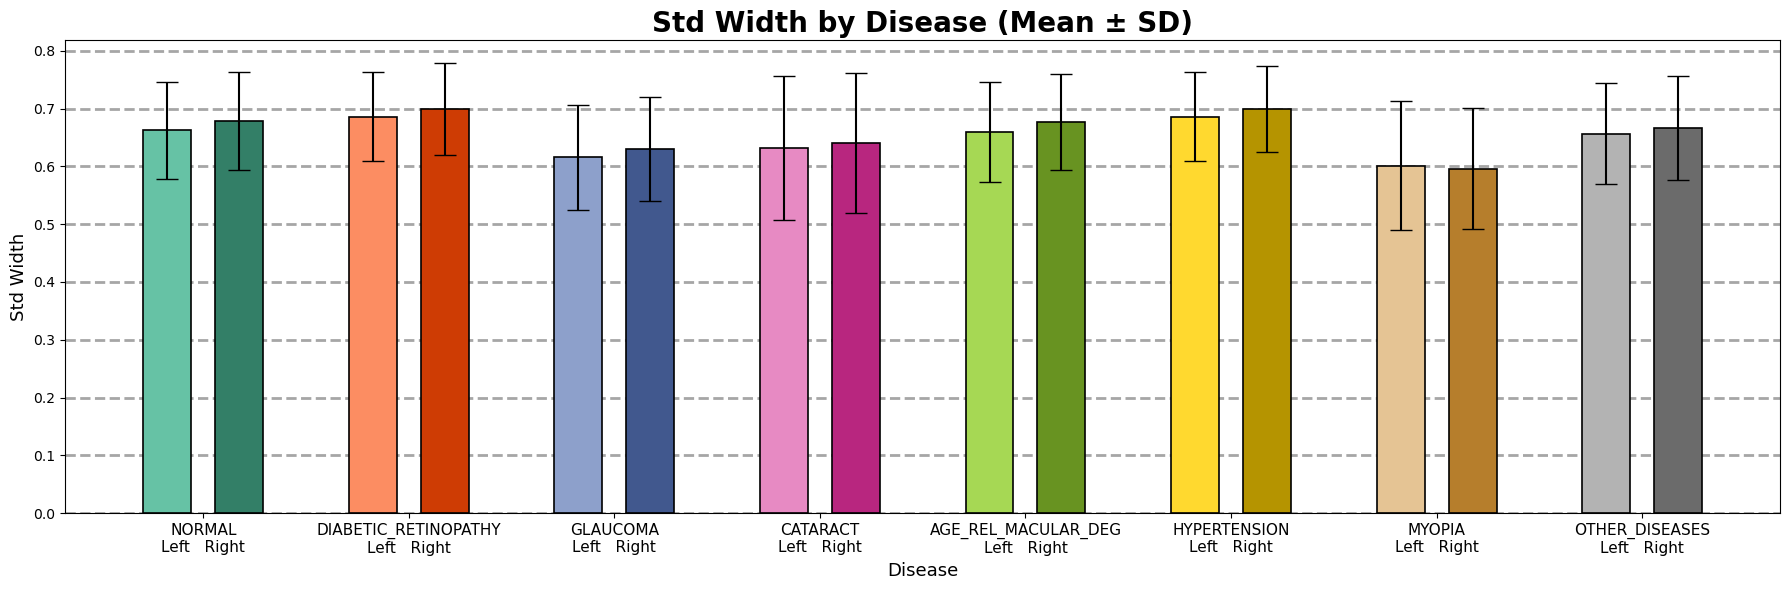

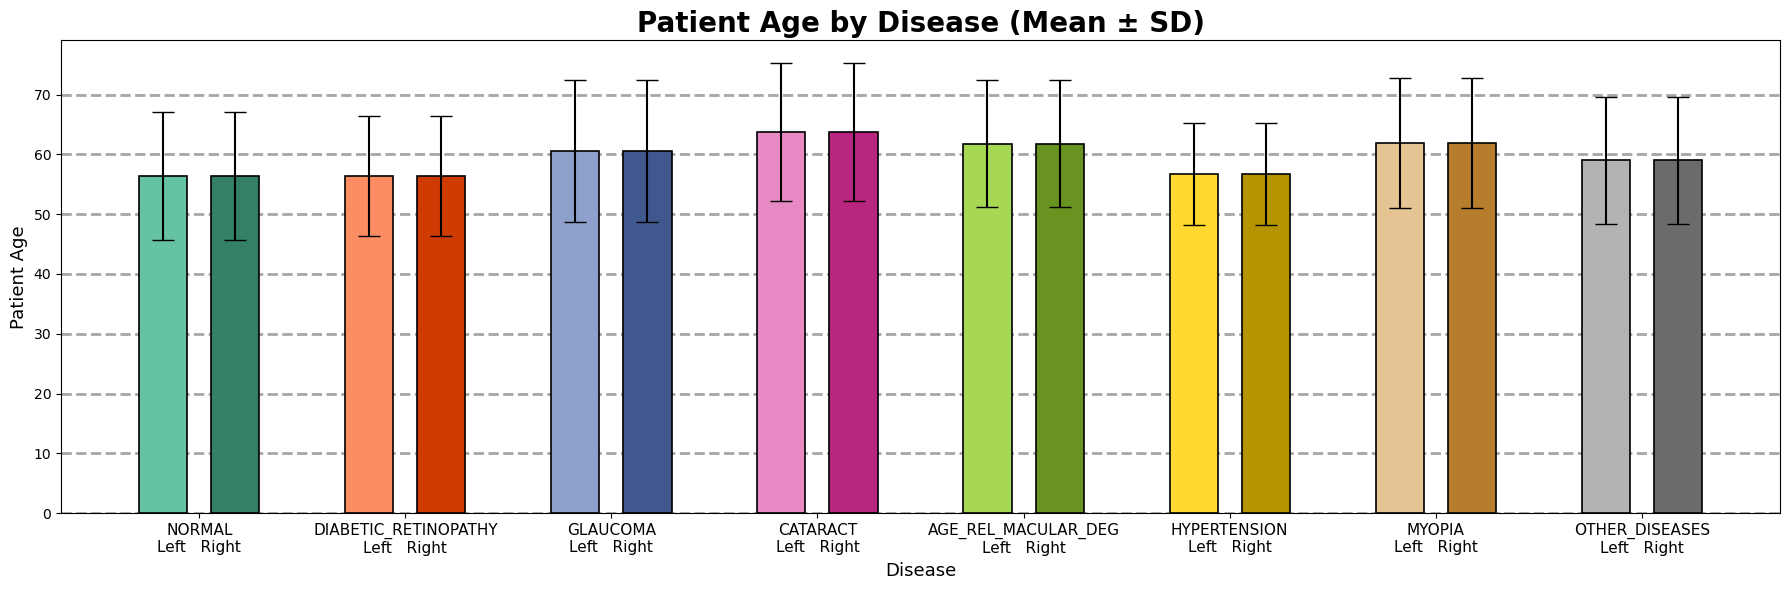

In [114]:
def plot_measurement_bars(left_df, right_df, measurement_base, title_prefix):
    disease_order = [disease_name_map[d] for d in diseases]
    palette = sns.color_palette('Set2', len(disease_order))

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    for i, (eye_df, eye_title) in enumerate(zip([left_df, right_df], ['Left Eye', 'Right Eye'])):
        eye_df = eye_df.set_index('Disease').reindex(disease_order)

        mean_col = f'{measurement_base} Mean'
        se_col = f'{measurement_base} SE'

        means = eye_df[mean_col]
        ses = eye_df[se_col]
        labels = eye_df.index.tolist()

        axes[i].bar(labels, means, yerr=ses, capsize=5, color=palette, edgecolor='black')
        axes[i].set_title(f'{title_prefix} - {eye_title}', fontsize=14)
        axes[i].set_ylabel(measurement_base, fontsize=12)
        axes[i].set_xlabel('Disease', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def darken_color(color, amount=0.6):
    """Darken a matplotlib color."""
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    darker = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return darker

def plot_combined_eyes_barplot(left_df, right_df, measurement_base, title):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    disease_order = [disease_name_map[d] for d in diseases]
    base_colors = sns.color_palette('Set2', len(disease_order))

    # Reindex for consistent order
    left_df = left_df.set_index('Disease').reindex(disease_order)
    right_df = right_df.set_index('Disease').reindex(disease_order)

    mean_col = f'{measurement_base} Mean'
    sd_col = f'{measurement_base} SD'

    x = np.arange(len(disease_order))
    width = 0.35

    fig, ax = plt.subplots(figsize=(18, 6))

    for i, disease in enumerate(disease_order):
        # Left eye bar
        ax.bar(x[i] - width/2,
               left_df.loc[disease, mean_col],
               yerr=left_df.loc[disease, sd_col],
               width=width / 1.5,
               color=base_colors[i],
               edgecolor='black',
               capsize=8,
               linewidth=1.2)

        # Right eye bar
        ax.bar(x[i] + width/2,
               right_df.loc[disease, mean_col],
               yerr=right_df.loc[disease, sd_col],
               width=width / 1.5,
               color=darken_color(base_colors[i]),
               edgecolor='black',
               capsize=8,
               linewidth=1.2)

    # Custom x labels with eye labels
    x_labels = [f"{disease}\nLeft   Right" for disease in disease_order]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0, fontsize=11)

    # Horizontal dotted gridlines
    ax.yaxis.grid(True, linestyle='--', linewidth=2, color='gray', alpha=0.7)
    ax.set_axisbelow(True)  # Ensure grid is behind bars

    ax.set_ylabel(measurement_base, fontsize=13)
    ax.set_xlabel("Disease", fontsize=13)
    ax.set_title(title, fontsize=20, weight='bold')

    plt.tight_layout()
    plt.show()
# Plot all measurements
# for measure in clean_measurements:
#     plot_combined_eyes_barplot(left_stats_se, right_stats_se, measure, title=f'{measure} by Disease (Mean ± SE)')
for measure in clean_measurements:
    plot_combined_eyes_barplot(left_stats_sd, right_stats_sd, measure, title=f'{measure} by Disease (Mean ± SD)')

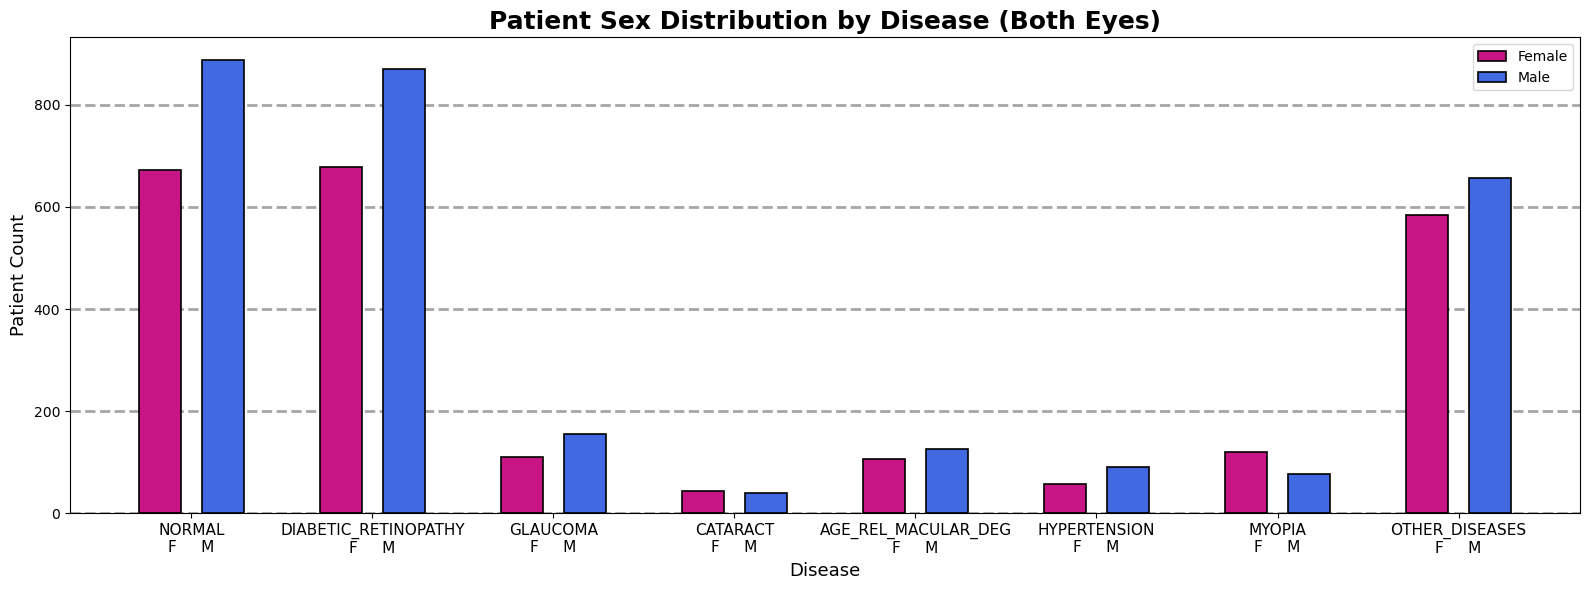

In [119]:
def plot_sex_distribution(df, eye_label):
    disease_order = df['Disease'].tolist()
    female_counts = df.set_index('Disease').loc[disease_order]['Female']
    male_counts = df.set_index('Disease').loc[disease_order]['Male']

    x = np.arange(len(disease_order))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.bar(x - width/2, female_counts, width=width / 1.5, color='mediumvioletred', label='Female', edgecolor='black', linewidth=1.2)
    ax.bar(x + width/2, male_counts, width=width / 1.5, color='royalblue', label='Male', edgecolor='black', linewidth=1.2)

    x_labels = [f"{disease}\nF     M" for disease in disease_order]
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0, fontsize=11)

    ax.set_ylabel('Patient Count', fontsize=13)
    ax.set_xlabel('Disease', fontsize=13)
    ax.set_title(f'Patient Sex Distribution by Disease ({eye_label})', fontsize=18, weight='bold')
    ax.yaxis.grid(True, linestyle='--', linewidth=2, color='gray', alpha=0.7)
    ax.set_axisbelow(True)

    ax.legend()
    plt.tight_layout()
    plt.show()

plot_sex_distribution(left_stats_sd, 'Both Eyes')

In [ ]:
def plot_vessel_density_vs_name(name, df_stats, merged_df, title, eye_label):

    disease_order = [disease_name_map[d] for d in diseases if d != 'O']
    base_colors = sns.color_palette('Set2', len(disease_order))
    name_to_code = {v: k for k, v in disease_name_map.items()}

    df = df_stats.set_index('Disease').reindex(disease_order)
    x = np.arange(len(disease_order))
    width = 0.35

    # Get NORMAL data
    normal_code = name_to_code[name]
    normal_data = merged_df[merged_df[normal_code] == 1]['vessel_density'].astype(float)

    # Statistical tests
    pvals = []
    for disease in disease_order:
        if disease == name:
            continue
        code = name_to_code[disease]
        disease_data = merged_df[merged_df[code] == 1]['vessel_density'].astype(float)
        if len(disease_data) > 1 and len(normal_data) > 1:
            stat, p = ttest_ind(normal_data, disease_data, equal_var=False)
            pvals.append((disease, p))

    # FDR correction
    raw_pvals = [p for (_, p) in pvals]
    _, p_corrected, _, _ = multipletests(raw_pvals, method='fdr_bh')

    sig_map = {}
    for (disease, _), p_adj in zip(pvals, p_corrected):
        if p_adj < 0.001:
            sig_map[disease] = '***'
        elif p_adj < 0.01:
            sig_map[disease] = '**'
        elif p_adj < 0.05:
            sig_map[disease] = '*'
        else:
            sig_map[disease] = ''

    # Plot
    fig, ax = plt.subplots(figsize=(18, 8))
    bar_heights = df['Vessel Density Mean']
    bar_errors = df['Vessel Density SD']

    bars = ax.bar(x, bar_heights, yerr=bar_errors, capsize=6,
                  color=base_colors, edgecolor='black', linewidth=1.2)

    # Annotating brackets
    normal_idx = disease_order.index(name)
    h_base = max(bar_heights + bar_errors) + 0.01
    step = 0.015

    for i, disease in enumerate(disease_order):
        if disease == name:
            continue
        star = sig_map.get(disease, '')
        if not star:
            continue

        j = disease_order.index(disease)
        x1, x2 = x[normal_idx], x[j]
        y = h_base + step * i

        # Draw bracket: ┌────┐
        ax.plot([x1, x1, x2, x2], [y - 0.002, y, y, y - 0.002], lw=1.3, c='black')
        ax.text((x1 + x2)/2, y + 0.002, star, ha='center', va='bottom', fontsize=14)

    # Labels
    ax.set_xticks(x)
    ax.set_xticklabels(disease_order, rotation=45, ha='right')
    ax.set_ylabel('Vessel Density', fontsize=13)
    ax.set_xlabel('Disease', fontsize=13)
    ax.set_title(f'{title} ({eye_label})', fontsize=20, weight='bold')
    ax.yaxis.grid(True, linestyle='--', linewidth= 1.5, alpha=0.7)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

    # Print detailed stats
    print(f"\nStatistical comparison: {eye_label}")
    for (disease, p), p_adj in zip(pvals, p_corrected):
        star = sig_map[disease]
        print(f"{name} vs {disease}: p = {p_adj:.10f} ({p_adj:.2e}) → {star}")

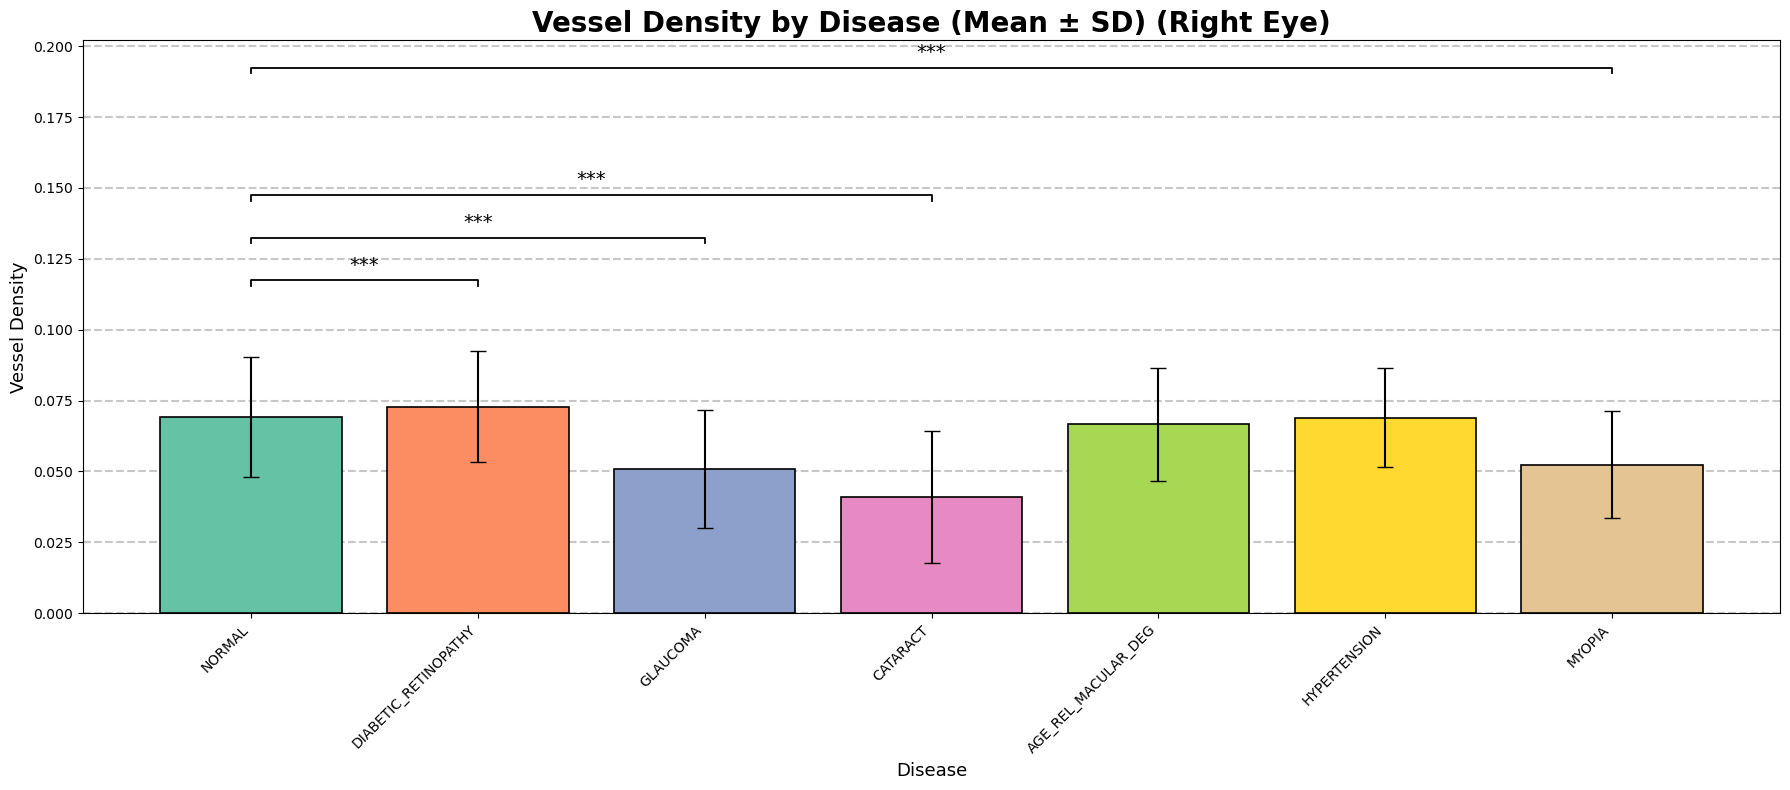


Statistical comparison: Right Eye
NORMAL vs DIABETIC_RETINOPATHY: p = 0.0000002170 (2.17e-07) → ***
NORMAL vs GLAUCOMA: p = 0.0000000000 (6.58e-32) → ***
NORMAL vs CATARACT: p = 0.0000000000 (1.84e-17) → ***
NORMAL vs AGE_REL_MACULAR_DEG: p = 0.0994250715 (9.94e-02) → 
NORMAL vs HYPERTENSION: p = 0.9808423207 (9.81e-01) → 
NORMAL vs MYOPIA: p = 0.0000000000 (1.50e-24) → ***


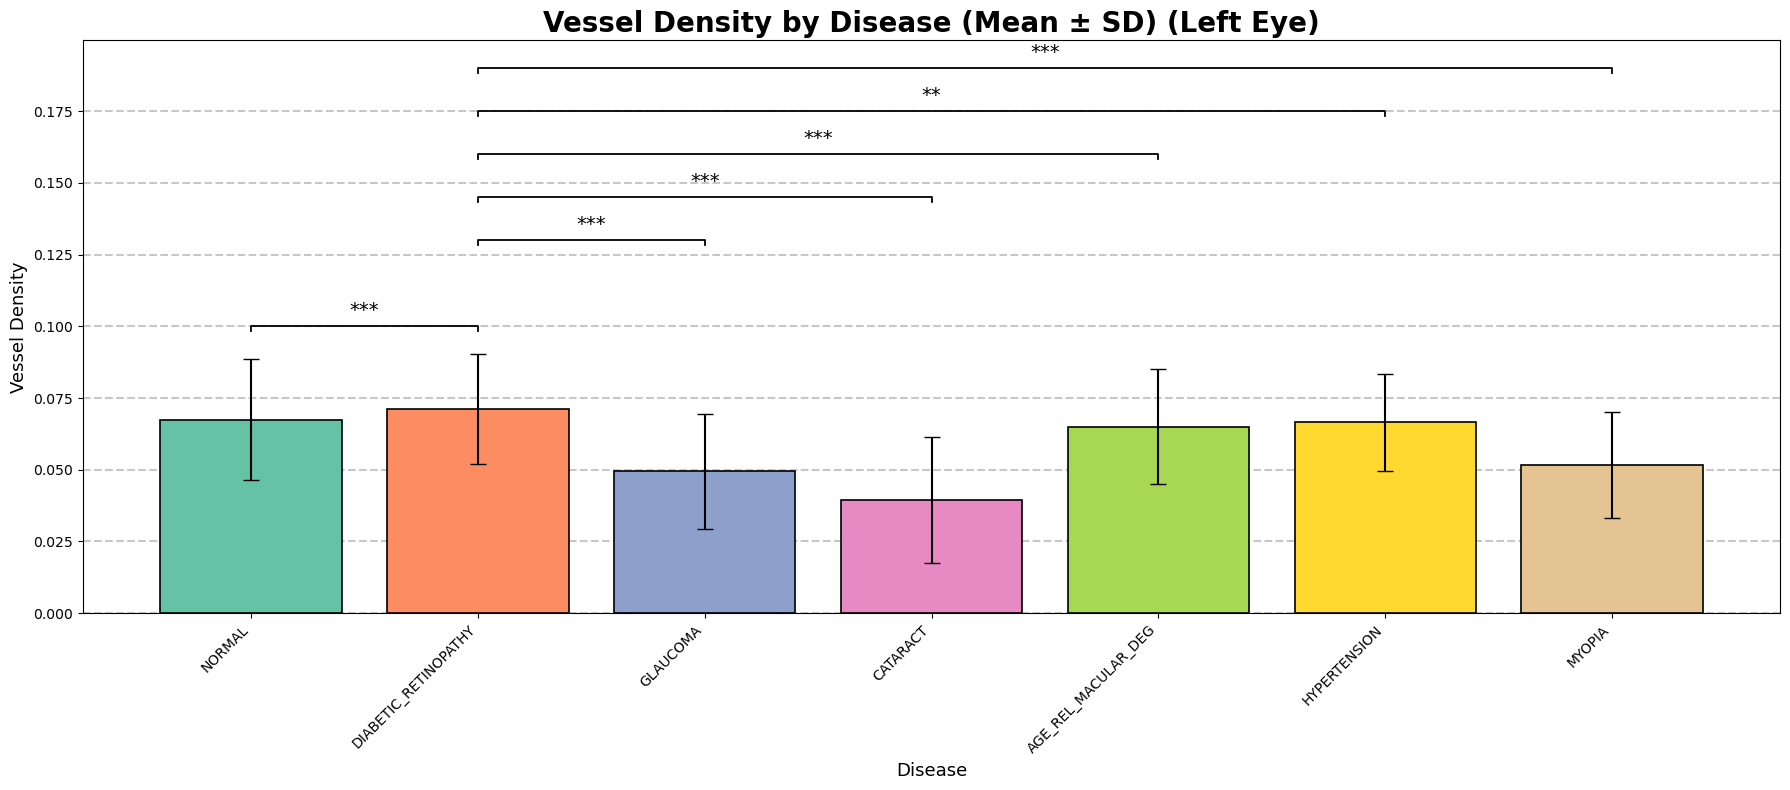


Statistical comparison: Left Eye
DIABETIC_RETINOPATHY vs NORMAL: p = 0.0000010543 (1.05e-06) → ***
DIABETIC_RETINOPATHY vs GLAUCOMA: p = 0.0000000000 (2.09e-44) → ***
DIABETIC_RETINOPATHY vs CATARACT: p = 0.0000000000 (8.57e-22) → ***
DIABETIC_RETINOPATHY vs AGE_REL_MACULAR_DEG: p = 0.0000222552 (2.23e-05) → ***
DIABETIC_RETINOPATHY vs HYPERTENSION: p = 0.0030554640 (3.06e-03) → **
DIABETIC_RETINOPATHY vs MYOPIA: p = 0.0000000000 (1.79e-32) → ***


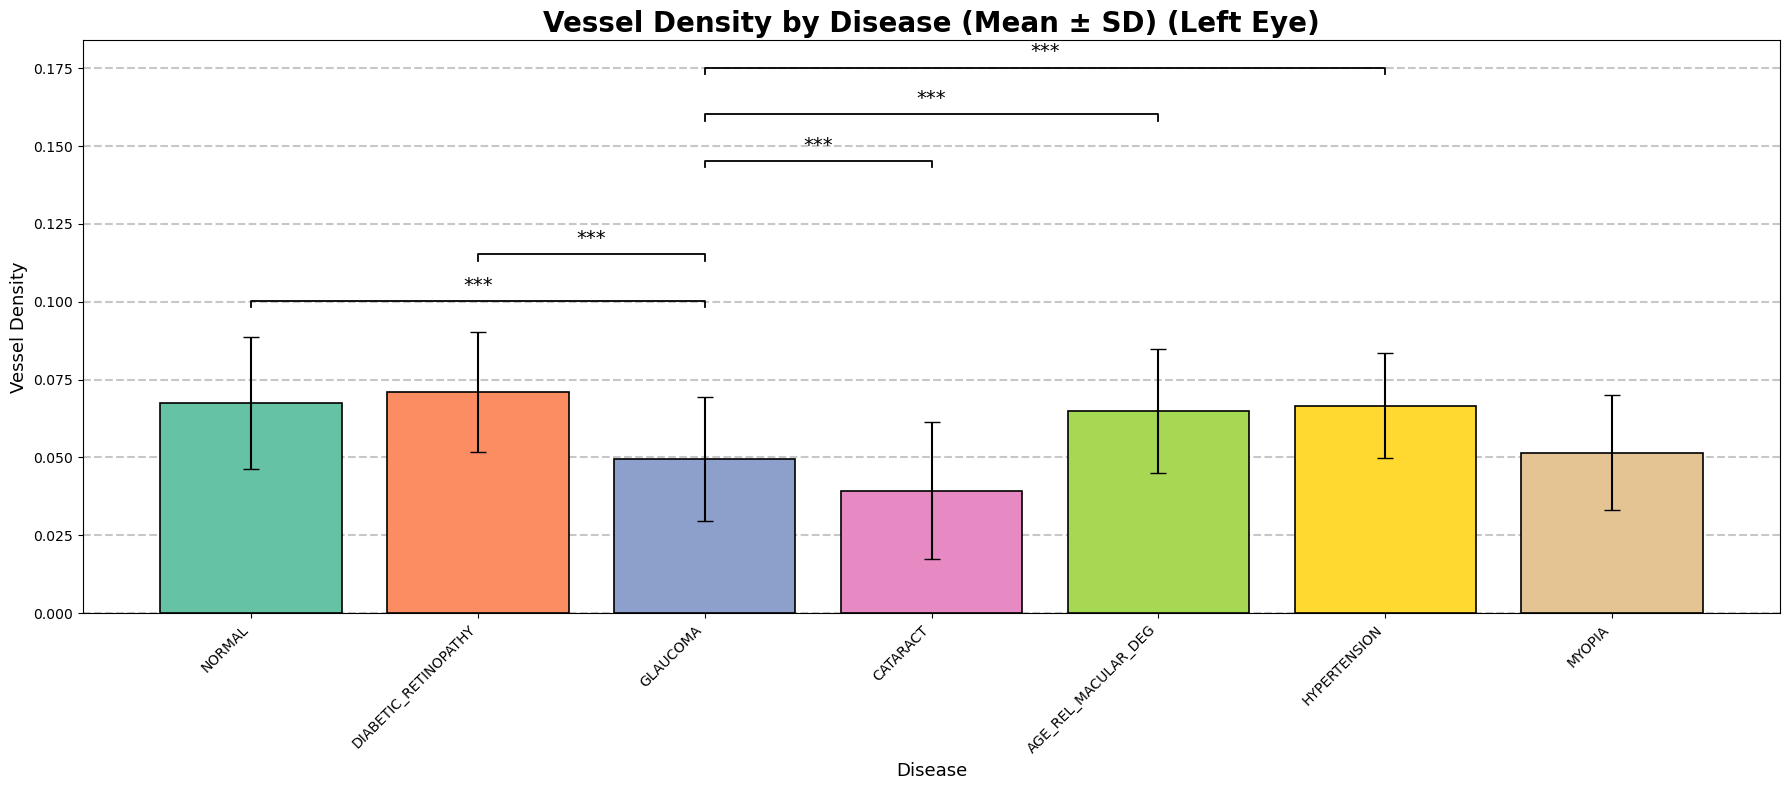


Statistical comparison: Left Eye
GLAUCOMA vs NORMAL: p = 0.0000000000 (1.96e-33) → ***
GLAUCOMA vs DIABETIC_RETINOPATHY: p = 0.0000000000 (2.09e-44) → ***
GLAUCOMA vs CATARACT: p = 0.0003195737 (3.20e-04) → ***
GLAUCOMA vs AGE_REL_MACULAR_DEG: p = 0.0000000000 (1.59e-16) → ***
GLAUCOMA vs HYPERTENSION: p = 0.0000000000 (5.08e-18) → ***
GLAUCOMA vs MYOPIA: p = 0.2393036266 (2.39e-01) → 


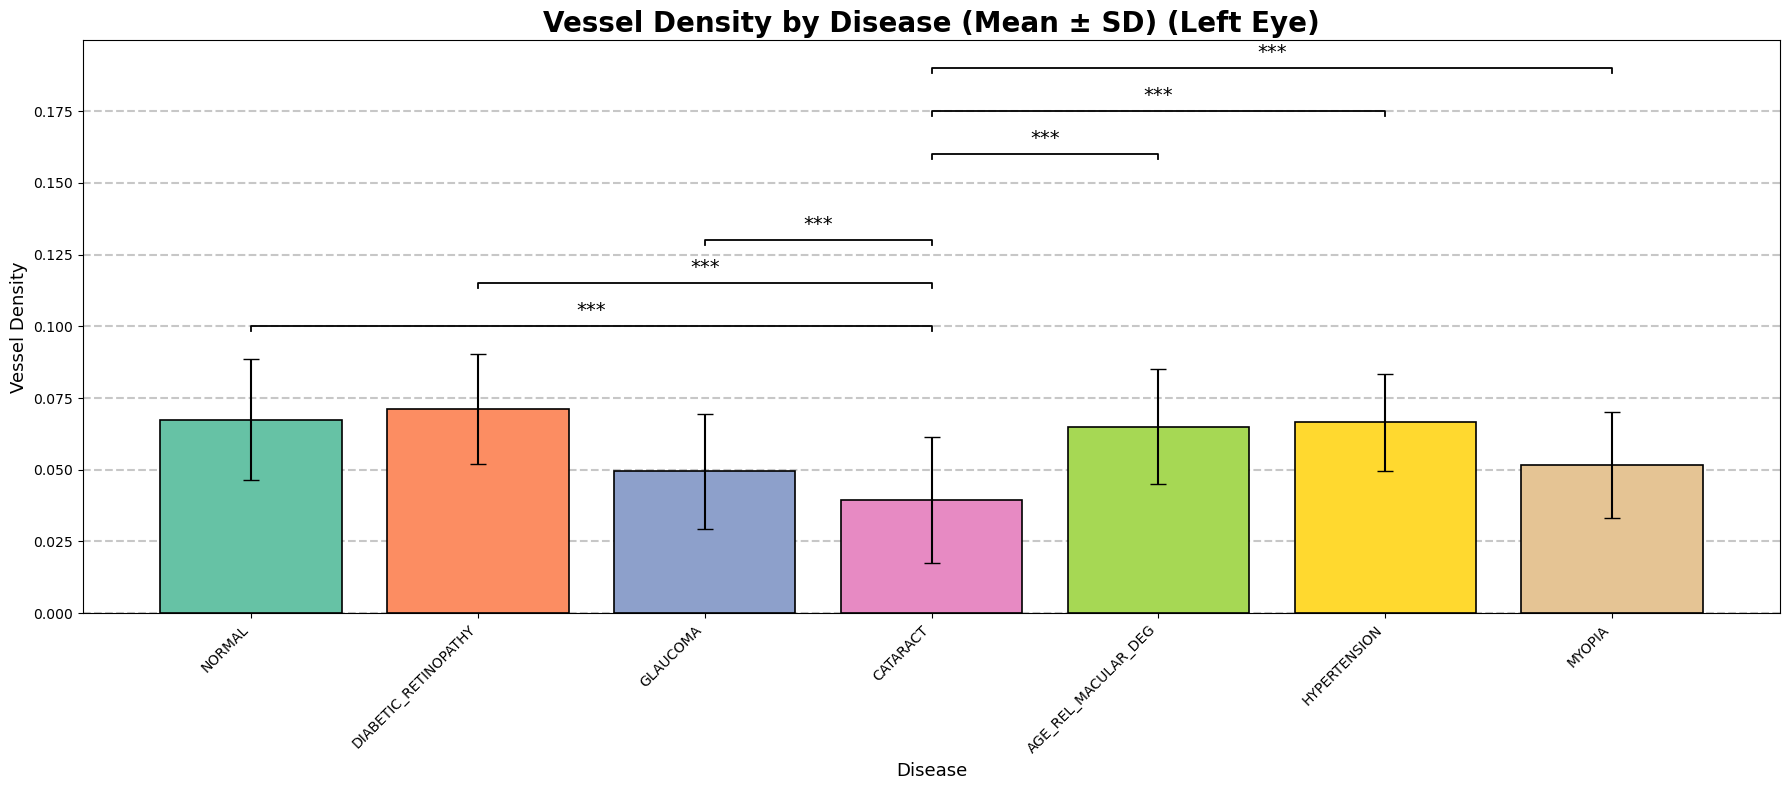


Statistical comparison: Left Eye
CATARACT vs NORMAL: p = 0.0000000000 (1.04e-18) → ***
CATARACT vs DIABETIC_RETINOPATHY: p = 0.0000000000 (2.57e-21) → ***
CATARACT vs GLAUCOMA: p = 0.0002663114 (2.66e-04) → ***
CATARACT vs AGE_REL_MACULAR_DEG: p = 0.0000000000 (4.31e-16) → ***
CATARACT vs HYPERTENSION: p = 0.0000000000 (3.04e-17) → ***
CATARACT vs MYOPIA: p = 0.0000201625 (2.02e-05) → ***


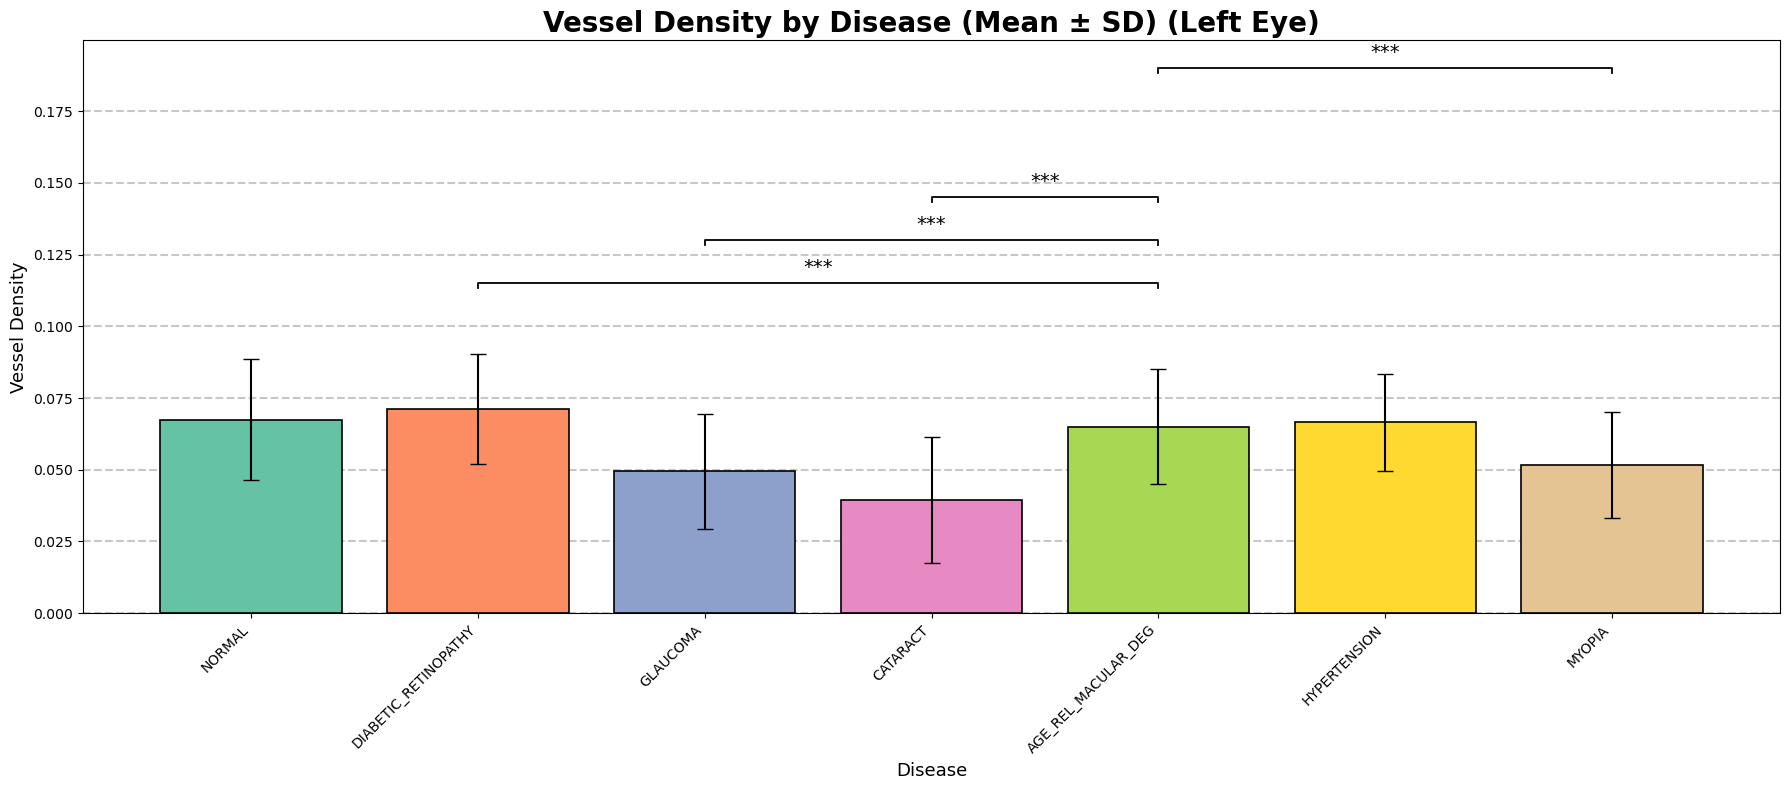


Statistical comparison: Left Eye
AGE_REL_MACULAR_DEG vs NORMAL: p = 0.0927851887 (9.28e-02) → 
AGE_REL_MACULAR_DEG vs DIABETIC_RETINOPATHY: p = 0.0000278190 (2.78e-05) → ***
AGE_REL_MACULAR_DEG vs GLAUCOMA: p = 0.0000000000 (6.38e-16) → ***
AGE_REL_MACULAR_DEG vs CATARACT: p = 0.0000000000 (8.62e-16) → ***
AGE_REL_MACULAR_DEG vs HYPERTENSION: p = 0.3825455714 (3.83e-01) → 
AGE_REL_MACULAR_DEG vs MYOPIA: p = 0.0000000000 (6.19e-12) → ***


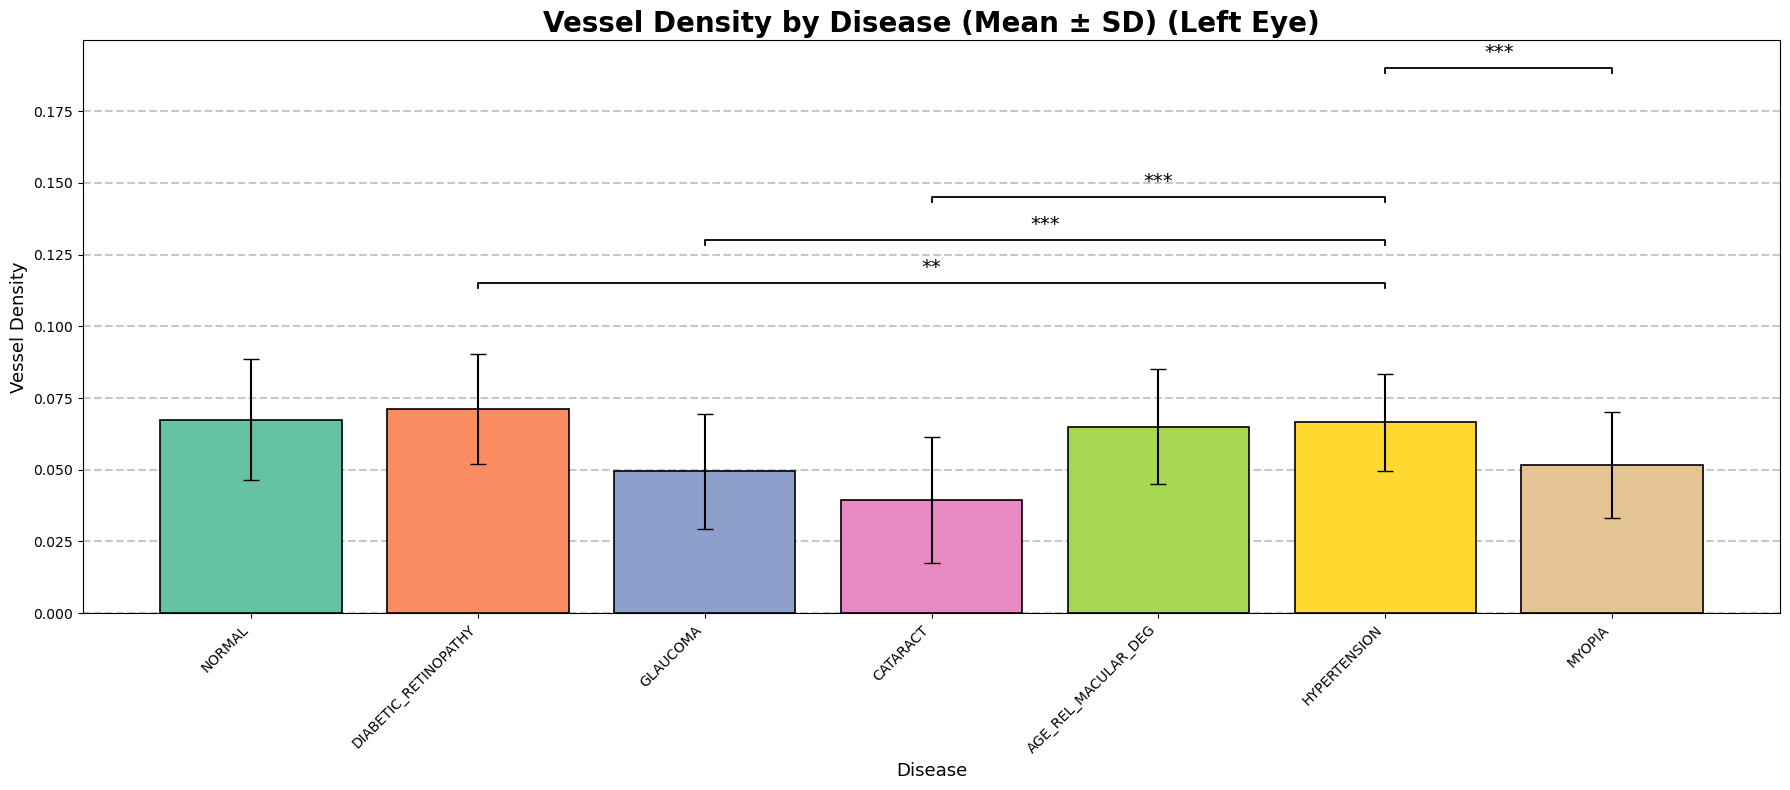


Statistical comparison: Left Eye
HYPERTENSION vs NORMAL: p = 0.5736175516 (5.74e-01) → 
HYPERTENSION vs DIABETIC_RETINOPATHY: p = 0.0045831959 (4.58e-03) → **
HYPERTENSION vs GLAUCOMA: p = 0.0000000000 (1.53e-17) → ***
HYPERTENSION vs CATARACT: p = 0.0000000000 (4.55e-17) → ***
HYPERTENSION vs AGE_REL_MACULAR_DEG: p = 0.4590546856 (4.59e-01) → 
HYPERTENSION vs MYOPIA: p = 0.0000000000 (1.20e-13) → ***


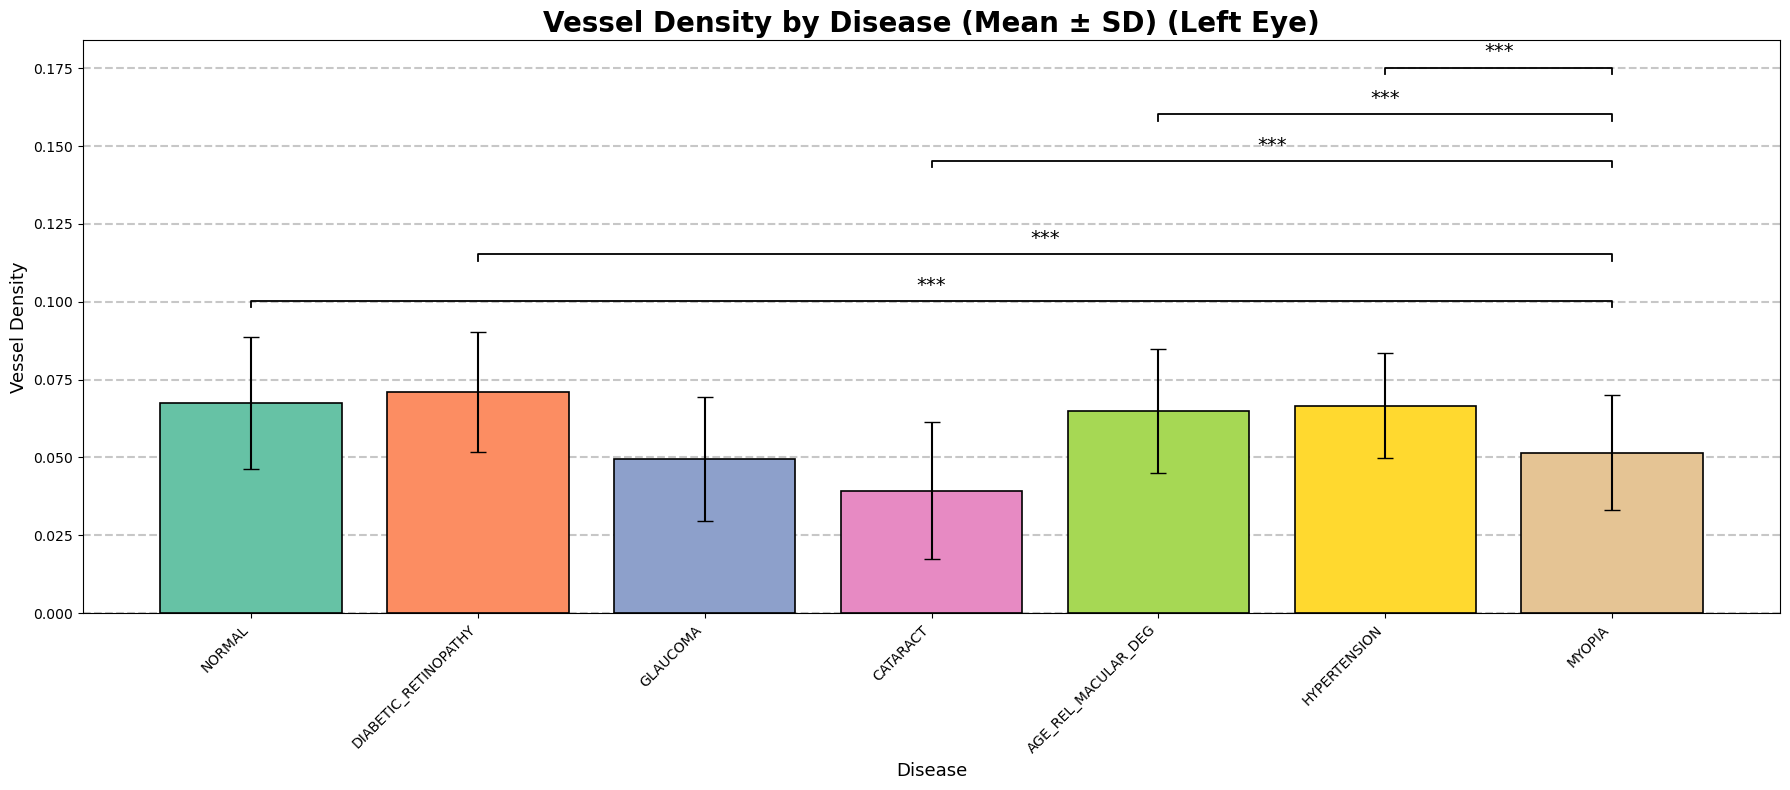


Statistical comparison: Left Eye
MYOPIA vs NORMAL: p = 0.0000000000 (1.41e-23) → ***
MYOPIA vs DIABETIC_RETINOPATHY: p = 0.0000000000 (3.58e-32) → ***
MYOPIA vs GLAUCOMA: p = 0.2393036266 (2.39e-01) → 
MYOPIA vs CATARACT: p = 0.0000201625 (2.02e-05) → ***
MYOPIA vs AGE_REL_MACULAR_DEG: p = 0.0000000000 (4.64e-12) → ***
MYOPIA vs HYPERTENSION: p = 0.0000000000 (1.20e-13) → ***


In [152]:
plot_vessel_density_vs_name('NORMAL',right_stats_sd, merged_data_right, "Vessel Density by Disease (Mean ± SD)", 'Right Eye')
plot_vessel_density_vs_name('DIABETIC_RETINOPATHY',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')
plot_vessel_density_vs_name('GLAUCOMA',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')
plot_vessel_density_vs_name('CATARACT',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')
plot_vessel_density_vs_name('AGE_REL_MACULAR_DEG',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')
plot_vessel_density_vs_name('HYPERTENSION',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')
plot_vessel_density_vs_name('MYOPIA',left_stats_sd, merged_data_left, "Vessel Density by Disease (Mean ± SD)", 'Left Eye')

In [218]:
def plot_pairwise_feature_significance(left_df_stats, right_df_stats, merged_df_left, merged_df_right,
                                       feature_col, title_prefix="Pairwise Significance"):
    disease_list = [disease_name_map[d] for d in diseases if d != 'O']
    name_to_code = {v: k for k, v in disease_name_map.items()}

    def compute_pval_matrix(df_stats, merged_df):
        pairs = []
        pvals = []
        for i, d1 in enumerate(disease_list):
            for j in range(i + 1, len(disease_list)):
                d2 = disease_list[j]
                code1, code2 = name_to_code[d1], name_to_code[d2]

                data1 = merged_df[merged_df[code1] == 1][feature_col].astype(float)
                data2 = merged_df[merged_df[code2] == 1][feature_col].astype(float)

                if len(data1) > 1 and len(data2) > 1:
                    stat, p = ttest_ind(data1, data2, equal_var=False)
                    pairs.append((d1, d2))
                    pvals.append(p)

        _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

        sig_matrix = pd.DataFrame('ns', index=disease_list, columns=disease_list)
        pval_matrix = pd.DataFrame(np.nan, index=disease_list, columns=disease_list)

        for (d1, d2), p_adj in zip(pairs, pvals_corrected):
            if p_adj < 0.001:
                sig = '***'
            elif p_adj < 0.01:
                sig = '**'
            elif p_adj < 0.05:
                sig = '*'
            else:
                sig = 'ns'
            sig_matrix.loc[d1, d2] = sig
            sig_matrix.loc[d2, d1] = sig
            pval_matrix.loc[d1, d2] = p_adj
            pval_matrix.loc[d2, d1] = p_adj

        return pval_matrix, sig_matrix

    # Compute stats
    pval_left, stars_left = compute_pval_matrix(left_df_stats, merged_df_left)
    pval_right, stars_right = compute_pval_matrix(right_df_stats, merged_df_right)

    fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharex=True, sharey=True)

    for ax, pval_matrix, star_matrix, eye in zip(
        axes, [pval_left, pval_right], [stars_left, stars_right], ['Left Eye', 'Right Eye']
    ):
        star_annot = star_matrix.copy()
        for i in range(len(disease_list)):
            for j in range(len(disease_list)):
                if j >= i or star_annot.iloc[i, j] == 'ns':
                    star_annot.iloc[i, j] = ''

        # Mask upper triangle
        mask_upper = np.triu(np.ones_like(pval_matrix, dtype=bool))

        # Use cmap with light gray masked regions
        cmap = sns.color_palette("vlag", as_cmap=True)
        cmap = cmap.with_extremes(bad='#eeeeee')  # visible light gray

        sns.heatmap(pval_matrix,
                    annot=star_annot,
                    fmt='',
                    cmap=cmap,
                    mask=mask_upper,
                    ax=ax,
                    cbar_kws={"label": "Corrected p-value"},
                    vmin=0,
                    vmax=0.05,
                    linewidths=0.5,
                    linecolor='gray',
                    square=True,
                    annot_kws={'size': 15, 'weight': 'bold'})

        # Force draw outermost gridlines
        n = len(disease_list)
        ax.plot([0, 0, n, n, 0], [0, n, n, 0, 0], color='gray', lw=2, zorder=9)

        ax.set_title(f"{title_prefix} ({eye})", fontsize=18, weight='bold')
        ax.tick_params(axis='x', rotation=45, size=20)
        ax.tick_params(axis='y', rotation=0, size=20)
        ax.set_xlim(0, n)
        ax.set_ylim(n, 0)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

    # Print tables
    # print("\nCorrected p-value matrix (Left Eye):")
    # display(pval_left.round(5))

    # print("\nCorrected p-value matrix (Right Eye):")
    # display(pval_right.round(5))


    return pval_left, pval_right

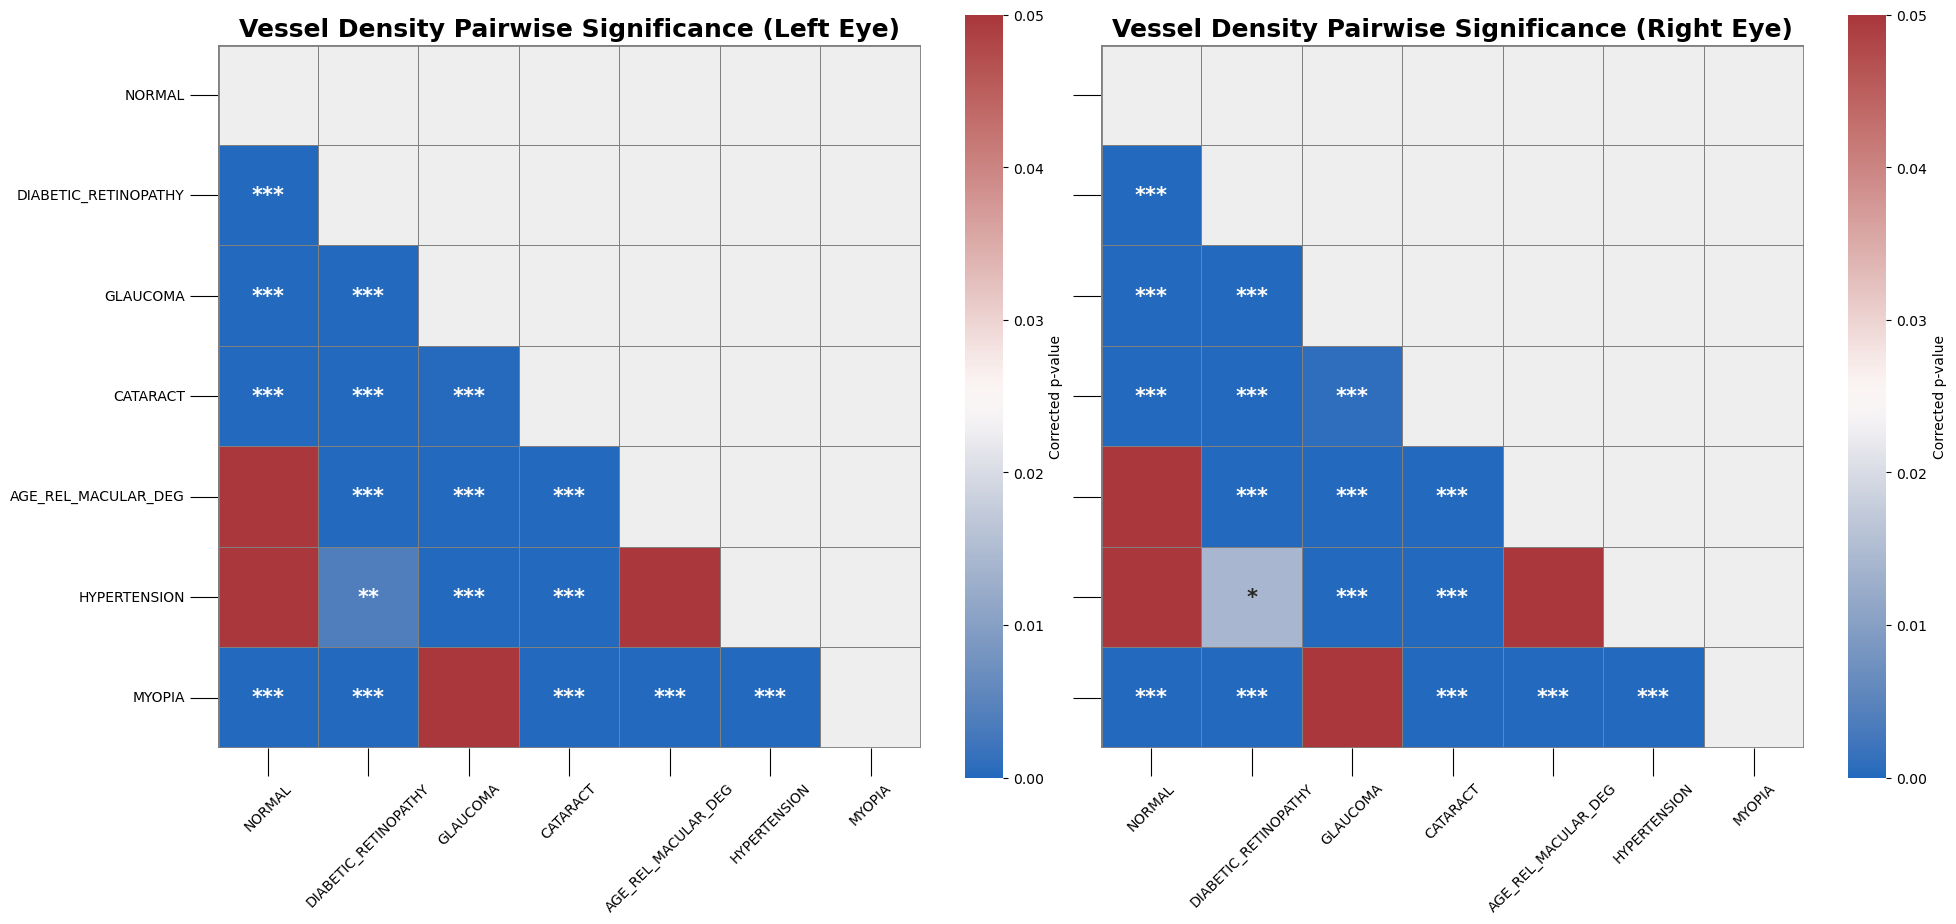

In [219]:
# For vessel density
pval_left_dens, pval_right_dens = plot_pairwise_feature_significance(
    left_stats_sd, right_stats_sd,
    merged_data_left, merged_data_right,
    feature_col='vessel_density',
    title_prefix='Vessel Density Pairwise Significance'
)

In [229]:
display(scrollable_df(pval_left_dens.round(5)))
display(scrollable_df(pval_right_dens.round(5)))

,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.00000,0.00000,0.09021,0.57362,0.00000
DIABETIC_RETINOPATHY,0.00000,NaN,0.00000,0.00000,0.00003,0.00377,0.00000
GLAUCOMA,0.00000,0.00000,NaN,0.00035,0.00000,0.00000,0.26449
CATARACT,0.00000,0.00000,0.00035,NaN,0.00000,0.00000,0.00003
AGE_REL_MACULAR_DEG,0.09021,0.00003,0.00000,0.00000,NaN,0.40167,0.00000
HYPERTENSION,0.57362,0.00377,0.00000,0.00000,0.40167,NaN,0.00000
MYOPIA,0.00000,0.00000,0.26449,0.00003,0.00000,0.00000,NaN


,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.00000,0.00000,0.09666,0.98084,0.00000
DIABETIC_RETINOPATHY,0.00000,NaN,0.00000,0.00000,0.00002,0.01407,0.00000
GLAUCOMA,0.00000,0.00000,NaN,0.00096,0.00000,0.00000,0.41545
CATARACT,0.00000,0.00000,0.00096,NaN,0.00000,0.00000,0.00017
AGE_REL_MACULAR_DEG,0.09666,0.00002,0.00000,0.00000,NaN,0.23418,0.00000
HYPERTENSION,0.98084,0.01407,0.00000,0.00000,0.23418,NaN,0.00000
MYOPIA,0.00000,0.00000,0.41545,0.00017,0.00000,0.00000,NaN


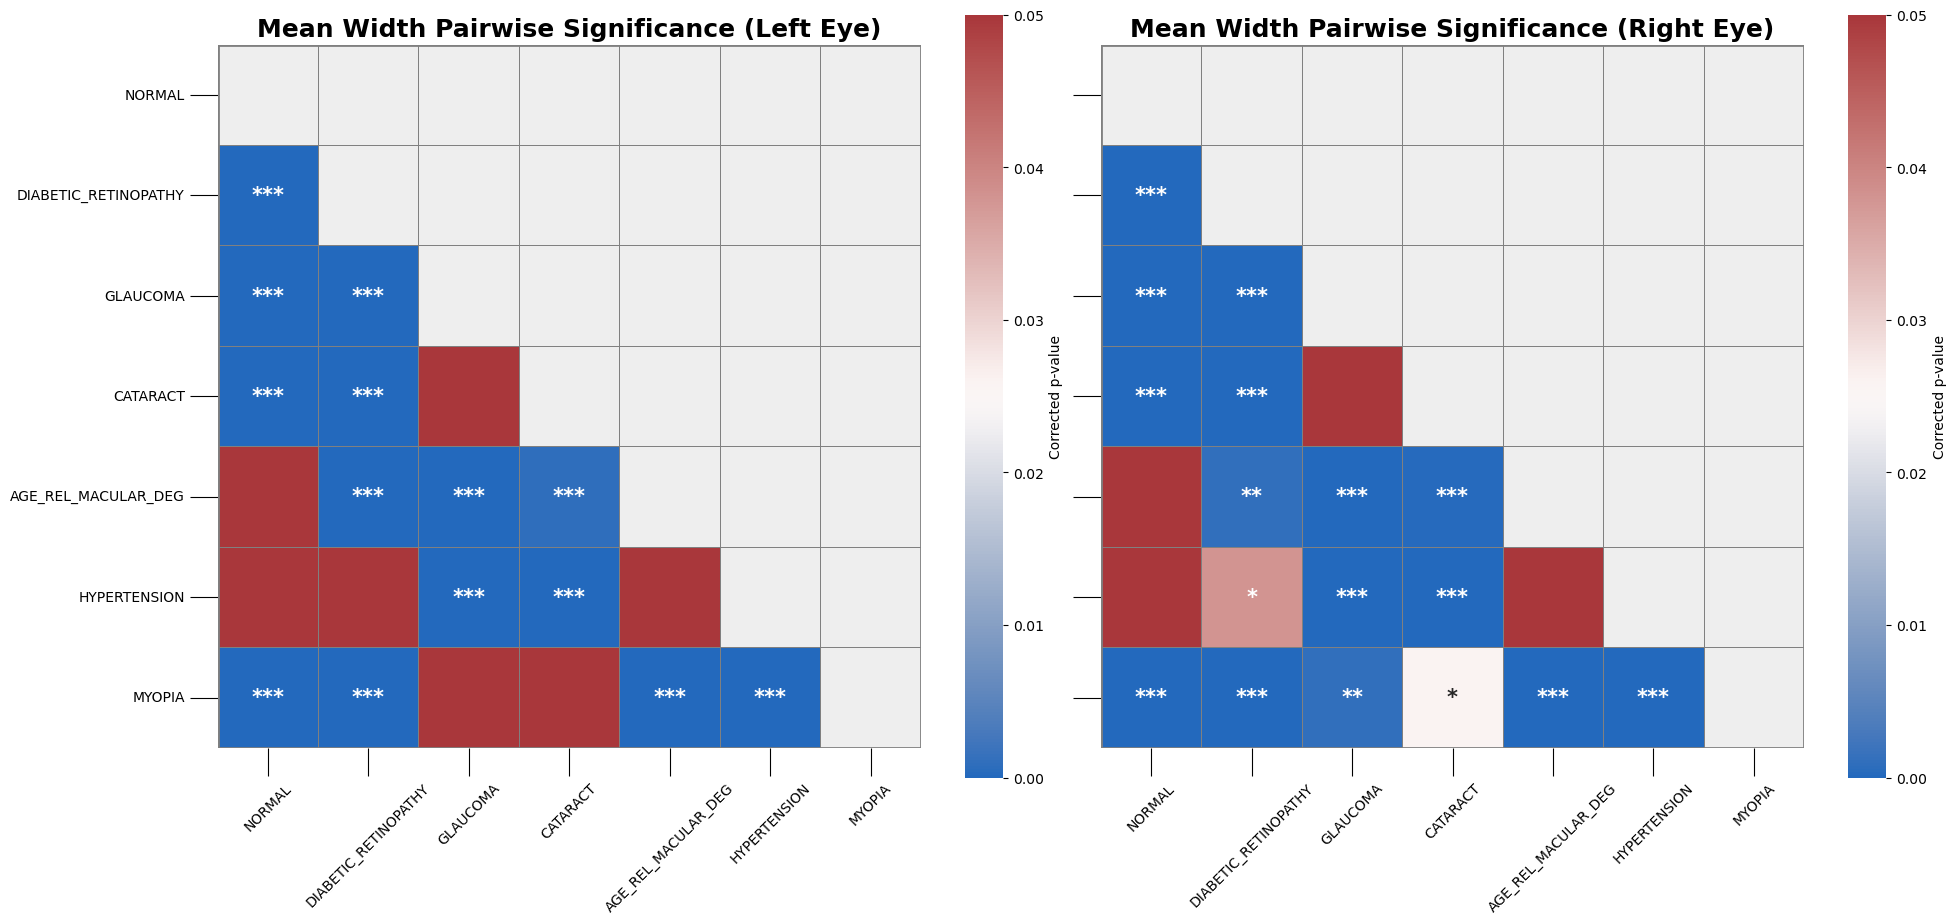

In [220]:
# For width
pval_left_width, pval_right_width = plot_pairwise_feature_significance(
    left_stats_sd, right_stats_sd,
    merged_data_left, merged_data_right,
    feature_col='mean_width',
    title_prefix='Mean Width Pairwise Significance'
)

In [231]:
display(scrollable_df(pval_left_width.round(5)))
display(scrollable_df(pval_right_width.round(5)))

,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.00000,0.00011,0.52152,0.28765,0.00000
DIABETIC_RETINOPATHY,0.00000,NaN,0.00000,0.00000,0.00019,0.08808,0.00000
GLAUCOMA,0.00000,0.00000,NaN,0.71277,0.00000,0.00000,0.16694
CATARACT,0.00011,0.00000,0.71277,NaN,0.00083,0.00005,0.22594
AGE_REL_MACULAR_DEG,0.52152,0.00019,0.00000,0.00083,NaN,0.21234,0.00000
HYPERTENSION,0.28765,0.08808,0.00000,0.00005,0.21234,NaN,0.00000
MYOPIA,0.00000,0.00000,0.16694,0.22594,0.00000,0.00000,NaN


,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.00000,0.00005,0.75152,0.56546,0.00000
DIABETIC_RETINOPATHY,0.00000,NaN,0.00000,0.00000,0.00103,0.03791,0.00000
GLAUCOMA,0.00000,0.00000,NaN,0.79508,0.00000,0.00000,0.00103
CATARACT,0.00005,0.00000,0.79508,NaN,0.00021,0.00005,0.02591
AGE_REL_MACULAR_DEG,0.75152,0.00103,0.00000,0.00021,NaN,0.50922,0.00000
HYPERTENSION,0.56546,0.03791,0.00000,0.00005,0.50922,NaN,0.00000
MYOPIA,0.00000,0.00000,0.00103,0.02591,0.00000,0.00000,NaN


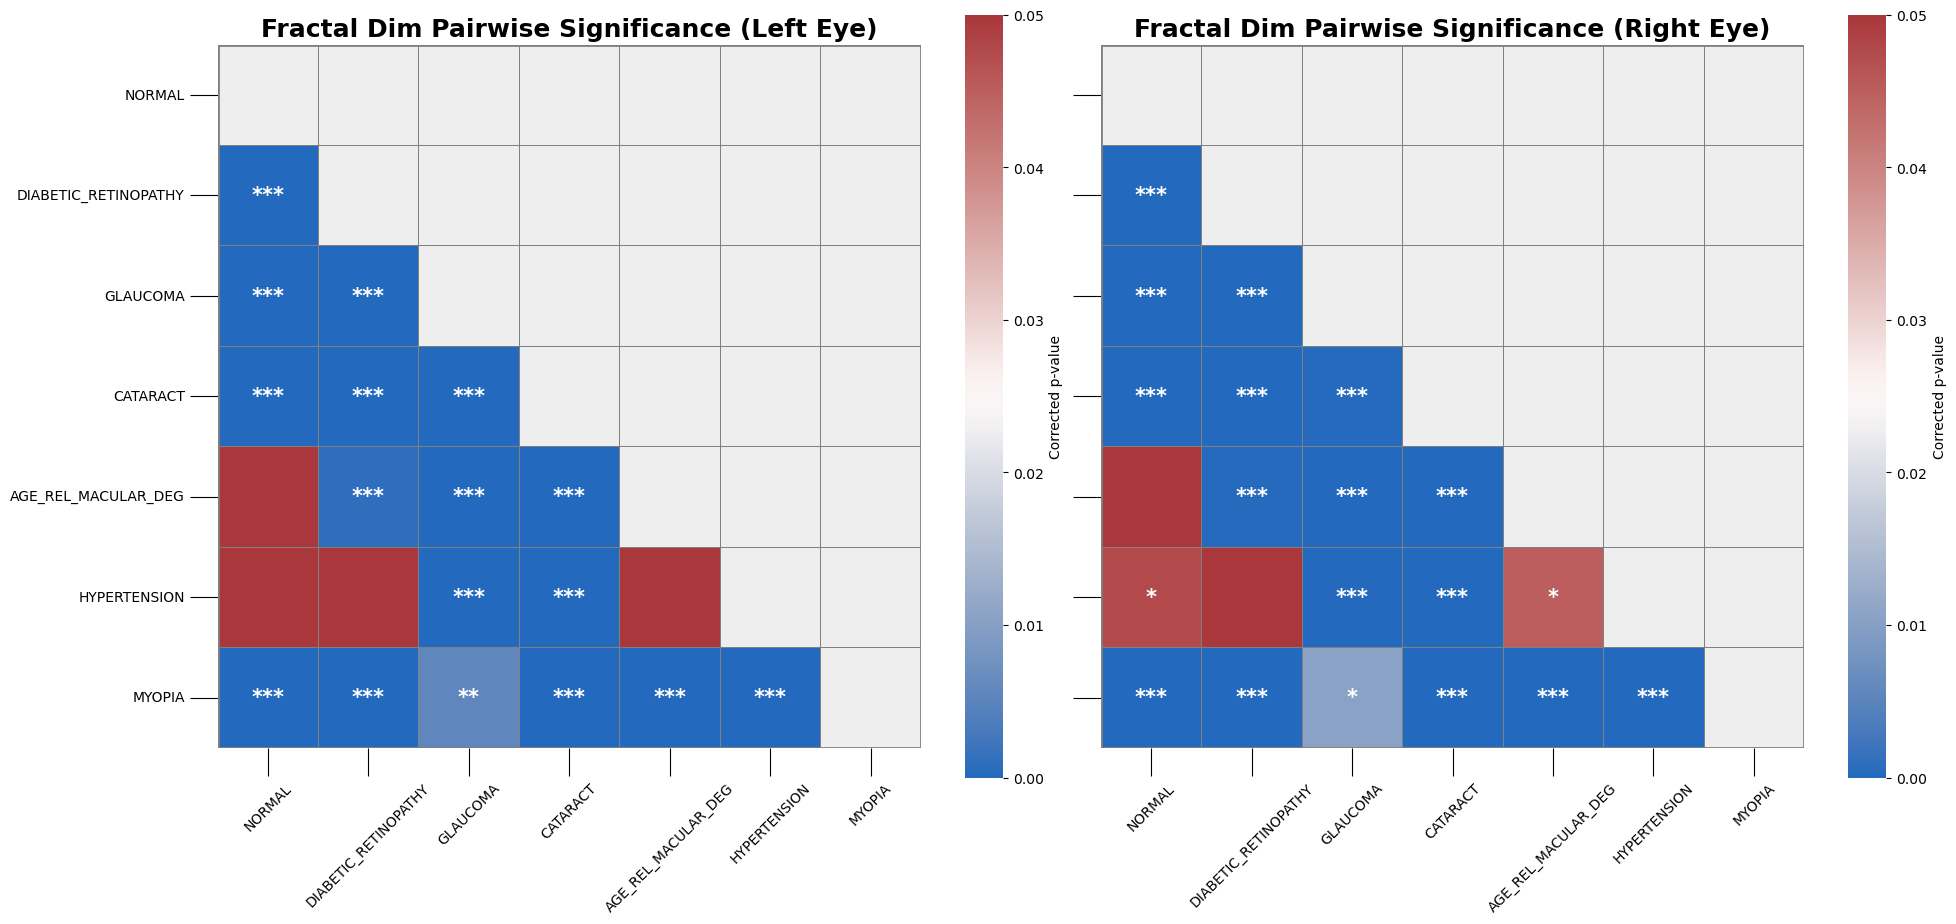

In [221]:
# For vessel Fractal Dim
pval_left_fractal, pval_right_fractal = plot_pairwise_feature_significance(
    left_stats_sd, right_stats_sd,
    merged_data_left, merged_data_right,
    feature_col='fractal_dim',
    title_prefix='Fractal Dim Pairwise Significance'
)

In [230]:
display(scrollable_df(pval_left_fractal.round(5)))
display(scrollable_df(pval_right_fractal.round(5)))

,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.00000,0.00000,0.66582,0.09740,0.00000
DIABETIC_RETINOPATHY,0.00000,NaN,0.00000,0.00000,0.00094,0.23841,0.00000
GLAUCOMA,0.00000,0.00000,NaN,0.00018,0.00000,0.00000,0.00558
CATARACT,0.00000,0.00000,0.00018,NaN,0.00000,0.00000,0.00000
AGE_REL_MACULAR_DEG,0.66582,0.00094,0.00000,0.00000,NaN,0.10627,0.00000
HYPERTENSION,0.09740,0.23841,0.00000,0.00000,0.10627,NaN,0.00000
MYOPIA,0.00000,0.00000,0.00558,0.00000,0.00000,0.00000,NaN


,NORMAL,DIABETIC_RETINOPATHY,GLAUCOMA,CATARACT,AGE_REL_MACULAR_DEG,HYPERTENSION,MYOPIA
NORMAL,NaN,0.00000,0.0000,0.0000,0.49547,0.04762,0.0000
DIABETIC_RETINOPATHY,0.00000,NaN,0.0000,0.0000,0.00035,0.39435,0.0000
GLAUCOMA,0.00000,0.00000,NaN,0.0002,0.00000,0.00000,0.0105
CATARACT,0.00000,0.00000,0.0002,NaN,0.00000,0.00000,0.0000
AGE_REL_MACULAR_DEG,0.49547,0.00035,0.0000,0.0000,NaN,0.04508,0.0000
HYPERTENSION,0.04762,0.39435,0.0000,0.0000,0.04508,NaN,0.0000
MYOPIA,0.00000,0.00000,0.0105,0.0000,0.00000,0.00000,NaN
